In [1]:
import scipy as sp
from pyscf import gto, dft, lib, mp, cc, scf, tools, ci, fci

In [2]:
import numpy as np
import sys
sys.path.append( './src/' )

In [3]:
matrix_dot = lambda A, B: np.einsum('ij,ij', A, B)

In [4]:
# H    0.7493682,0.0000000,0.4424329
# O    0.0000000,0.0000000,-0.1653507
# H   -0.7493682,0.0000000,0.4424329

# Define Molecule 

- Note first N atoms will be the ACTIVE portion of the molecule
- the remaining atoms will be the environment

In [389]:
geometry = [
['H@1', (0.7493682,0.0000000,0.4424329)],
['O@1', (0.0000000,0.0000000,-0.1653507)],
    
['H#', (-0.7493682,0.0000000,0.4424329)]
]

# geometry = [
# ['Be@1', (0.0000000,0.0000000,0.0000000)],
# ['H@1', (0.0000000,0.0000000,+1)],
    
# ['H#', (0.0000000,0.0000000,-1)]
# ]

# geometry = [
# ['Li', (0.0000000,0.0000000,0.0000000)],
# ['H', (0.0000000,0.0000000,+1.54)],
    
# ]

<IPython.core.display.Javascript object>


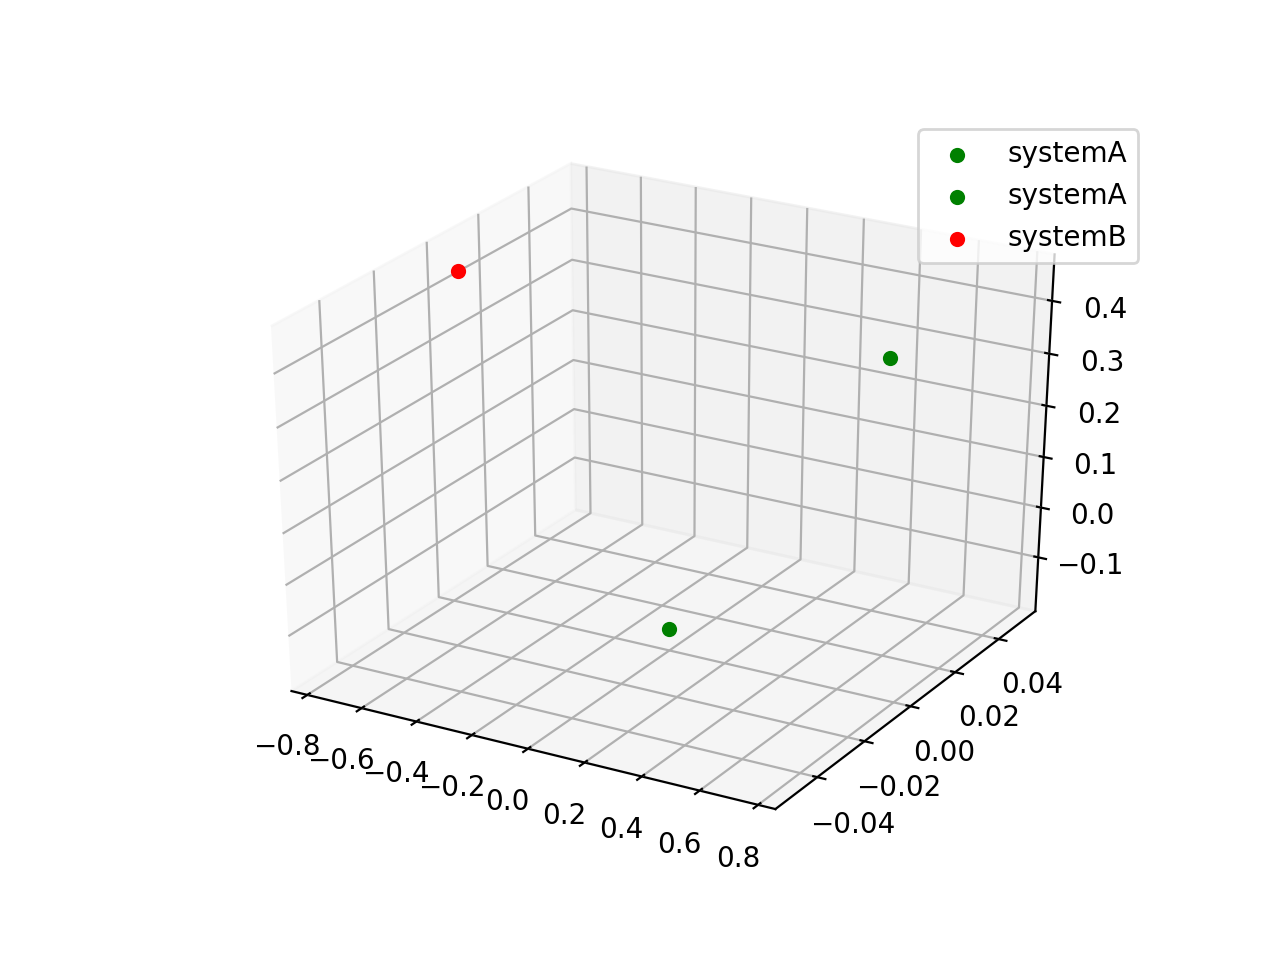

In [390]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*geometry[0][1:][0], marker='o', color='green', label='systemA')
ax.scatter(*geometry[1][1:][0], marker='o', color='green', label='systemA')

for x in range(2, len(geometry)):
    ax.scatter(*geometry[x][1:][0], marker='o', color='red', label='systemB')
plt.legend()
plt.show()


# Define Params

- what level to treat active and envirnoment systems

In [552]:
## define params

basis =  'STO-3G' # '6-31g' #
low_level_xc_functional_or_HF = 'lda, vwn' #'hf'
high_level_xc_functional = 'b3lyp'

low_level_method = 'rhf'
high_level_ref = 'rhf'
high_level_method = 'CCSD'

# Build the GLOBAL (full) molecule

In [553]:
full_system_mol = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol.build()
full_system_mol.atom

[['H@1', (0.7493682, 0.0, 0.4424329)],
 ['O@1', (0.0, 0.0, -0.1653507)],
 ['H#', (-0.7493682, 0.0, 0.4424329)]]

In [393]:
full_system_mol.verbose = 1
full_system_mol.max_memory = 8_000 #MB

# Run Supersystem Calculation (cheap method)

In [554]:
full_system_scf = scf.RKS(full_system_mol)
full_system_scf.verbose=1
full_system_scf.max_memory= 8_000
full_system_scf.conv_tol = 1e-6
full_system_scf.xc = low_level_xc_functional_or_HF
full_system_scf.kernel()

-74.73474041595249

In [395]:
full_system_scf.e_tot

-75.8177697773331

In [12]:
full_system_scf.conv_check

True

In [13]:
two_e_term_total = full_system_scf.get_veff()
e_xc_total = two_e_term_total.exc
v_xc_total = two_e_term_total - full_system_scf.get_j() 

In [14]:
# full_system_scf.get_fock()
# full_system_scf.get_hcore()

In [15]:
# full_system_scf.mo_coeff

# Run expensive CI calc to compare all results too

In [555]:
HF_scf = scf.RHF(full_system_mol)
HF_scf.verbose=1
HF_scf.max_memory= 8_000
HF_scf.conv_tol = 1e-6
HF_scf.kernel()

my_fci = fci.FCI(HF_scf).run()
print('E(UHF-FCI) = %.12f' % my_fci.e_tot)

# myci = ci.CISD(HF_scf).run() # this is UCISD
# print('UCISD total energy = ', myci.e_tot)

E(UHF-FCI) = -75.015352478525


# Localise orbitals

### Background

The overlap matrix is:

$$S_{\mu \nu} =  \int d\vec{r}_{1} \phi_{\mu}(1)^{*}\phi_{\nu}(1)$$

- $\phi_{\mu}$ are basis functions (defined in basis set)


The unknown molecular orbitals $\psi_{i}$ are expanded as a linear expansion of the $K$ known basis functions:

$$ \psi_{i} =  \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu}$$


$C$ is a $K \times K$ matrix of expansion coefficients $C_{\mu i}$. The columns of $C$ describe the molecular orbitals!

We can find the total number of electrons $N$ in the system by:

$$ N =  2 \sum_{a}^{N/2}\int d\vec{r}  \bigg( \psi_{a}(\vec{r})^{*} \psi_{i}(\vec{r}) \bigg) =  2 \sum_{a}^{N/2} 1$$

- integral gives probablity of finding electron $a$ over all space (must be 1)
- summing over all electrons will give the total number of electrons

The charge density has the following definition:

$$\rho(\vec{r}) = 2 \sum_{a}^{N/2} \bigg( \psi_{a}(\vec{r})^{*} \psi_{i}(\vec{r}) \bigg)$$

- re-write using definition of $\psi_{i}=  \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu}$

$$\rho(\vec{r}) = 2 \sum_{a}^{N/2} \Bigg( \bigg[ \sum_{\nu}^{K} C_{\nu a}^{*} \phi_{\nu}(\vec{r})^{*} \bigg] \bigg[ \sum_{\mu}^{K} C_{\mu a}\phi_{\mu}(\vec{r}) \bigg] \Bigg)$$

- move things around

$$\rho(\vec{r}) = \sum_{\nu}^{K} \sum_{\mu}^{K} \Big( 2 \sum_{a}^{N/2} C_{\mu a} C_{\nu a}^{*} \Big) \phi_{\mu}(\vec{r}) \phi_{\nu}(\vec{r})^{*} $$

- which is 

$$\rho(\vec{r}) = \sum_{\mu, \nu}^{K} P_{\mu \nu} \phi_{\mu}(\vec{r}) \phi_{\nu}(\vec{r})^{*} $$


- $P_{\mu \nu}$ is known as the density matrix and is:

$$P_{\mu \nu} = 2 \sum_{a}^{N/2} C_{\mu a} C_{\nu a}^{*}$$

Therefore we can also find the total number of electrons in the system by:

$$ N =  2 \sum_{a}^{N/2}\int d\vec{r}  \bigg( \psi_{a}(\vec{r})^{*} \psi_{i}(\vec{r}) \bigg) =  \sum_{\nu}^{K} \sum_{\mu}^{K} \Big( 2 \sum_{a}^{N/2} C_{\mu a} C_{\nu a}^{*} \Big) \int d\vec{r} \phi_{\mu}(\vec{r})  \phi_{\nu}(\vec{r})^{*}$$

- This is simply:

$$N =  \sum_{\nu}^{K} \sum_{\mu}^{K} P_{\mu \nu} S_{\nu \mu}$$

- in an orthognal basis $S$ should be the identity matrix (as it is overlap of matrix of orthogonal orbs), SO WE GET:

$$N =  \sum_{\nu}^{K} \sum_{\mu}^{K} P_{\mu \nu} S_{\nu \mu} = \sum_{\mu}^{K} PS_{\mu \mu} = \mathcal{Tr}(PS)$$

In [396]:
S_mat = full_system_scf.get_ovlp()
print(np.around(S_mat))

[[ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0. -0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -0. -0.  0.  0.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  1.  1.]
 [ 0.  1.  0.  0.  1. -0.  0.  0. -0.  0.  0.  1.  1.]]


- One can interpret $ PS_{\mu \mu}$ in the above equation as the number of electrons associated with $ \phi_{\mu}$
- This is a **Mulliken population analysis**

# Orbital Localization!

In [18]:
from pyscf import lo

A molecular orbital is usually delocalized, i.e. it has non-negligible amplitude over the whole system rather than only around some atom(s) or bond(s). However, one can choose a unitary rotation 

- When we perform a SCF calculation, one gets an optimized C matrix
    - $C$ is a $K \times K$ matrix of expansion coefficients $C_{\mu i}$
    - The columns of $C$ describe the molecular orbitals!
    - MO i: $ \psi_{i} =  \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu}$
    
    
- These molecular orbitals are usually **delocalized**
    - non-negligible amplitude over the whole system, rather than only around some atom(s) or bond(s)

- But we know in QM that a given basis choice is NOT unique


- We can therefore perform a unitary rotation on molecular orbitals

$$ \psi_{i} U_{rot} =  \Big( \sum_{\mu=1}^{K} C_{\mu i} \psi_{\mu} \Big) U_{rot} = \psi_{i}^{new}$$
    
    
The idea is to use a rotation such that the resulting orbitals $\psi_{i}^{new}$ are as spatially localized as possible. 


The Pipek-Mezey (PM) [localization](https://notendur.hi.is/hj/papers/paperPipekmezey8.pdf) **maximizes the population charges on the atoms**:

$$ f (U_{rot}) = \sum_{A}^{N_{atoms}} \Bigg( Z_{A} -  \sum_{\mu \text{ on atom } A} PS_{\mu \mu} \Bigg)$$

In [719]:
# # Take occupied orbitals of global system calc
# occ_orbs = full_system_scf.mo_coeff[:,full_system_scf.mo_occ>0]

# # run localization scheme
# PM = lo.PipekMezey(full_system_mol, occ_orbs)
# PM.pop_method = 'mulliken' # 'meta-lowdin', 'iao', 'becke'
# C_mull = PM.kernel()

# C_loc_occ = PM.mo_coeff # <-- these are the NEW C matrix (where orbitals are localized to atoms)

In [20]:
# np.array_equal(C_mull, C_loc_occ)

In [714]:
# Take C matrix from SCF calc
opt_C = full_system_scf.mo_coeff

# run localization scheme
PM = lo.PipekMezey(full_system_mol, opt_C)
PM.pop_method = 'mulliken' # 'meta-lowdin', 'iao', 'becke'
C_mull = PM.kernel()

C_loc = PM.mo_coeff # <-- these are the NEW C matrix (where orbitals are localized to atoms)

In [715]:
np.array_equal(C_mull, C_loc)

True

In [720]:
C_loc_occ

array([[-6.45006669e-06,  3.12148509e-01,  4.41344968e-01,
        -1.03542124e-01,  4.31965763e-17],
       [ 1.02263412e+00, -6.15813445e-02, -1.04826884e-15,
        -6.23342839e-02, -1.00895673e-15],
       [-1.49224444e-01,  2.16440393e-01,  1.38413897e-15,
         9.71848337e-01,  5.03227792e-16],
       [ 1.26291852e-15, -1.45091819e-15,  6.16645783e-01,
        -1.84529904e-15,  1.41570902e-16],
       [ 9.77444950e-16,  8.25007940e-17, -7.41910581e-17,
        -4.47656897e-16,  1.00000000e+00],
       [ 6.47650095e-02,  6.28244187e-01, -4.49514237e-16,
        -4.42656434e-01, -3.54726563e-16],
       [-6.45006669e-06,  3.12148509e-01, -4.41344968e-01,
        -1.03542124e-01, -1.49163209e-16]])

In [728]:
mo_occ = full_system_scf.mo_coeff[:,full_system_scf.mo_occ>0]
iaos = lo.iao.iao(full_system_mol, mo_occ)

ibo = lo.ibo.ibo(full_system_mol, mo_occ, locmethod='PM', iaos=iaos).kernel()
C_loc_occ = ibo
# for i in range(ibo.shape[1]):
#     tools.cubegen.orbital(mol, 'benzene_ibo2_{:02d}.cube'.format(i+1), ibo[:,i])

In [732]:
sum(np.abs(C_loc_occ[:,3])**2)

1.181667282802784

In [723]:
## check number of electrons is still the same 
# should be the same after change of basis has been done

C_loc_occ = C_loc[:,full_system_scf.mo_occ>0]

dm_localised = 2* C_loc_occ @ C_loc_occ.conj().T
S = full_system_scf.get_ovlp()

print(np.isclose(np.trace(dm_localised@S), full_system_mol.nelectron))

True


In [24]:
# ## check number of electrons is still the same 
# # should be the same after change of basis has been done

# dm_localised = 2* C_loc_occ @ C_loc_occ.conj().T
# S = full_system_scf.get_ovlp()

# print(np.isclose(np.trace(dm_localised@S), full_system_mol.nelectron))

In [26]:
# (full_system_scf.mo_coeff@U)[0,0]
# C_loc_occ[0,0]

In [751]:
ci_psi_MO_0 = C_loc_occ[:, 0]

In [ ]:
np.einsum()

In [770]:
bra0_ketI = S[0, :]
bra0_ketI.shape

(7,)

In [765]:
bra0_ketI.dot(ci_psi_MO_0)

-0.0006648345987081833

In [738]:
ao_active_inds

array([0, 1, 2, 3, 4, 5])

In [774]:
(S@ C_loc_occ).shape 

(7, 5)

In [819]:
sum(np.matmul(S, C_loc_occ)[2,:])

1.468909481178076

In [818]:
np.einsum('ij->j', S@C_loc_occ)

array([1.1439079 , 2.61967966, 0.8845425 , 0.86998559, 1.        ])

In [884]:
def AO_overlap_with_MO(AO_ind, S_matrix, MO_ci):
    
    bra_I_ketAO = S_matrix[AO_ind, :] # [ < AO_i | AO_0> , < AO_i | AO_1>, ..., < AO_i | AO_M> ]
    
    AO_i_overlap_MO = np.dot(bra_I_ketAO.T, MO_ci) # < ϕ_AO_i |ψ_MO> = Σ_j  (c_j < ϕ_AO_i | ϕ_AO_j >)
    
    return AO_i_overlap_MO

In [888]:
ao_active_inds

for mo_ind in range(C_loc_occ.shape[1]):
    MO_orb = C_loc_occ[:, mo_ind]
    ovlp=0
    for active_AO_index in ao_active_inds:
        ovlp+=AO_overlap_with_MO(active_AO_index, S, MO_orb)
    print(f'active overlap: {ovlp} with MO {mo_ind}')

active overlap: 1.1445727332101583 with MO 0
active overlap: 1.9697799405458494 with MO 1
active overlap: 1.399503169539902 with MO 2
active overlap: 0.6695685885747844 with MO 3
active overlap: 0.9999999997212239 with MO 4


In [883]:
orthogonal_C_loc = S_half @ C_loc_occ

psi = orthogonal_C_loc[:,0]
psi2 = orthogonal_C_loc[:,3]
psi.dot(psi2)

np.einsum('ij->j', orthogonal_C_loc[ao_active_inds, :]) 

array([1.03048698, 1.46171879, 1.21725182, 0.43679776, 1.        ])

In [866]:
MO_ind = 0
a= AO_overlap_with_MO(0, S, C_loc_occ[:,MO_ind])
b= AO_overlap_with_MO(1, S, C_loc_occ[:,MO_ind])
c= AO_overlap_with_MO(2, S, C_loc_occ[:,MO_ind])
d= AO_overlap_with_MO(3, S, C_loc_occ[:,MO_ind])
e= AO_overlap_with_MO(4, S, C_loc_occ[:,MO_ind])
f= AO_overlap_with_MO(5, S, C_loc_occ[:,MO_ind])
g= AO_overlap_with_MO(6, S, C_loc_occ[:,MO_ind])
sum([a, b, c, d, e, f, g])
# sum([a, b, c, d, e, f])

1.1439078986114501

In [854]:
np.einsum('ij->j', (S[:, ao_active_inds] @ C_loc_occ[ao_active_inds, :] ))

array([1.15257486, 2.08587093, 1.64485042, 1.05960256, 1.        ])

In [845]:
C_loc_occ[ao_active_inds, :].shape

(6, 5)

In [837]:
np.einsum('ij->j', (S@C_loc_occ))

array([1.1439079 , 2.61967966, 0.8845425 , 0.86998559, 1.        ])

# Choose active and environment systems

## METHOD 1 

- Given optimized $C$ coefficient matrix
    - which has been rotated to localize orbitals
    - (used to build localized density matrix)


- **Look through basis functions $\phi_{\mu}$ of the ACTIVE atoms**
    
    
- check the mulliken charge // mulliken population of the orbital
    - if above a certain threshold associate it to active system
    - otherwise put in the environment

In [401]:
## pyscf notes

# order of atoms in geometry is important
full_system_mol.atom

[['H@1', (0.7493682, 0.0, 0.4424329)],
 ['O@1', (0.0, 0.0, -0.1653507)],
 ['H#', (-0.7493682, 0.0, 0.4424329)]]

In [402]:
# aoslice_by_atom gives a matrix:
full_system_mol.aoslice_by_atom()

# where rows are defined by atoms (given by order in full_system_mol.atom - see cell above)
# the 3rd column gives first basis function index for THAT atom
# the last(4th) column gives the last basis function index for THAT atom

array([[ 0,  2,  0,  2],
       [ 2,  7,  2, 11],
       [ 7,  9, 11, 13]])

Therefore loop over basis function centered on the active atoms and find mulliken charge // population

In [560]:
ao_active_inds

array([0, 1, 2, 3, 4, 5])

In [617]:
dm_localised = 2* C_loc_occ @ C_loc_occ.conj().T
S = full_system_scf.get_ovlp()

In [621]:
dm_active = C_loc[ao_active_inds, :].conj().T @ C_loc[ao_active_inds, :]
np.trace(dm_active @ S)

np.diag(dm_active @ S)

array([1.03212025, 1.77165389, 1.42960498, 1.11052724, 1.        ,
       1.62930514, 0.2721825 ])

In [608]:
np.diag(dm_active @ S[ao_active_inds, :])

array([-0.1383957 ,  0.99550515,  1.31298899,  1.15493454,  1.        ,
        1.08333962])

In [595]:
SS = S[:, ao_active_inds]
SS = SS[ao_active_inds,:]
SS.shape

(6, 6)

In [570]:
C_loc_occ[:, ao_active_inds].shape

IndexError: index 5 is out of bounds for axis 1 with size 5

In [589]:
# sum(PS[:,3])
loc_dm = 2* C_loc_occ.conj().T @ C_loc_occ

np.trace(S@loc_dm)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 7)

In [590]:
# find indices of AO of active atoms
AO_slice_matrix = full_system_mol.aoslice_by_atom()
ao_active_inds = np.arange(AO_slice_matrix[0,2], AO_slice_matrix[N_active_atoms-1,3])

loc_dm = 2* C_loc_occ@C_loc_occ.conj().T
PS = loc_dm@S
np.einsum('ij->j', PS[ao_active_inds, :])/2
# MO_active_inds = []
# for mo_orb_loc_ind in range(C_loc_occ.shape[1]):
    
#     mo_overlap_with_active_ao = sum(C_loc_occ[ao_active_inds , mo_orb_loc_ind])
#     print(mo_overlap_with_active_ao)
#     if mo_overlap_with_active_ao>THRESHOLD:
#         mo_overlap_with_active_ao.append(mo_orb_loc_ind)
    

# note only using OCCUPIED C_loc_occ
# active_AO_MO_overlap = np.einsum('ij->j', C_loc_occ[ao_active_inds, :]) # s

array([0.49404619, 0.99250377, 0.93356931, 0.85069059, 1.        ,
       0.96519304, 0.20602398])

New understanding

- C_localized contains localized set of MOs $\{ \psi \}$ (columns of C_localized!)
- Next take active AOs $\{ \phi \}$ defined by active system and find overlap with MOs
    - this involves adding the active ROWs (active AO components)

TODO: could expand to full C_loc matrix (rather than taking of C_loc_occ aka use C_loc[ao_active_inds, :]) in einsum

... Look at AO overlaps here also give importance of virtual (unoccupied) MOs and overlap with basis function of active system! Could be used to reduce the active space!!!!

In [725]:
AO_slice_matrix = full_system_mol.aoslice_by_atom()
N_active_atoms = 2
THRESHOLD = 0.72

# find indices of AO of active atoms
ao_active_inds = np.arange(AO_slice_matrix[0,2], AO_slice_matrix[N_active_atoms-1,3])

# MO_active_inds = []
# for mo_orb_loc_ind in range(C_loc_occ.shape[1]):
    
#     mo_overlap_with_active_ao = sum(C_loc_occ[ao_active_inds , mo_orb_loc_ind])
#     print(mo_overlap_with_active_ao)
#     if mo_overlap_with_active_ao>THRESHOLD:
#         mo_overlap_with_active_ao.append(mo_orb_loc_ind)
    

# note only using OCCUPIED C_loc_occ
active_AO_MO_overlap = np.einsum('ij->j', C_loc_occ[ao_active_inds, :]) # sum columns (to give MO contibution from AO)

active_MO_inds = np.where(active_AO_MO_overlap>THRESHOLD)[0]
enviro_MO_inds = np.array([i for i in range(C_loc_occ.shape[1]) if i not in active_MO_inds])
active_MO_inds


array([1, 2, 3, 4])

In [726]:
active_AO_MO_overlap

array([0.70420702, 1.26977218, 0.8776978 , 0.74247113, 1.        ])

In [510]:
print(C_loc_occ.shape)
print(rotation_matrix2.T[ao_enviro_inds, :].shape)

(13, 5)
(2, 13)


In [547]:
# print(np.sum(np.abs((S_half@C_loc_occ)[ao_active_inds,2])**2))
# np.sum(np.abs((S_half@C_loc_occ)[:,2])**2)
ortho_localized_orbs =  S_half@C_loc_occ # 
np.einsum('ij->j', np.abs(ortho_localized_orbs)**2)
np.einsum('ij->j', np.abs(ortho_localized_orbs[ao_active_inds,:])**2)

# overlap_of_orbs = ortho_localized_orbs.conj().T@ortho_localized_orbs
# print(np.allclose(np.diag(overlap_of_orbs), np.ones(overlap_of_orbs.shape[0]))) # check self overlap =1)
# active_AO_MO_overlap = np.einsum('ij->j', overlap_of_orbs[ao_active_inds, :])
# np.where(active_AO_MO_overlap>0.9)[0]

array([0.99933754, 0.99063611, 0.99875147, 0.99851922, 1.        ])

In [512]:
# C_loc_occ[ao_enviro_inds, :] @ 
C_loc_occ @ (rotation_matrix2.T[ao_enviro_inds, :])
# rotation_matrix2.T[ao_enviro_inds, :].shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 5)

In [459]:
ao_enviro_inds = np.array([i for i in range(AO_slice_matrix[-1,3]) if i not in ao_active_inds])

In [500]:
S = full_system_scf.get_ovlp()
S_half = sp.linalg.fractional_matrix_power(S, 0.5)
ortho_localized_orbs =  S_half@C_loc #C_loc_occ # make sure localized MOs are orthogonal!

_, singular_values2, rotation_matrix2 = np.linalg.svd(ortho_localized_orbs[ao_active_inds, :], full_matrices=True)
act_orbitals = C_loc_occ @ rotation_matrix2.T#[:, ao_enviro_inds]
env_orbitals = C_loc_occ @ rotation_matrix2.T#[:, n_act_mos:]



# overlap_of_orbs = ortho_localized_orbs.conj().T@ortho_localized_orbs
# print(np.allclose(np.diag(overlap_of_orbs), np.ones(overlap_of_orbs.shape[0]))) # check self overlap =1)
# active_AO_MO_overlap = np.einsum('ij->j', overlap_of_orbs[ao_active_inds, :])
# np.where(active_AO_MO_overlap>0.9)[0]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 13 is different from 5)

In [388]:
# overlap_of_orbs.shape

In [357]:
# np.einsum('ij->j', np.abs(hcore_mo_occ[ao_active_inds, :]))

array([11.28499637,  9.68863687,  7.60996719,  7.45114291,  7.59707916])

In [38]:
enviro_MO_inds

array([0])

In [40]:
active_AO_MO_overlap

array([0.70420702, 1.26977218, 0.8776978 , 0.74247113, 1.        ])

In [41]:
with open('PM_LOCALIZED_orbs.molden', 'w') as outfile:
    tools.molden.header(full_system_mol, outfile)
    tools.molden.orbital_coeff(
                        full_system_mol,
                         outfile, 
                         C_loc, # <- all orbitals!
                         ene=full_system_scf.mo_energy,
                         occ=full_system_scf.mo_occ)

In [338]:
C_loc_occ.shape

(7, 5)

In [339]:
C_loc.shape

(7, 7)

## METHOD 2 - SPADE

In [44]:
###### SPADE

# Take occupied orbitals of global system calc
occ_orbs = full_system_scf.mo_coeff[:,full_system_scf.mo_occ>0]


N_active_AO = AO_slice_matrix[N_active_atoms-1][3]  # find max AO index for active atoms (neg 1 as python indexs from 0)

S_mat = full_system_scf.get_ovlp()
S_half = sp.linalg.fractional_matrix_power(S_mat, 0.5)
orthogonal_orbitals = (S_half@occ_orbs)[:N_active_AO, :]
# orthogonal_orbitals = occ_orbs[:N_active_AO, :] # take active rows and all columns

u, singular_values, rotation_matrix = np.linalg.svd(orthogonal_orbitals, full_matrices=True)

# find where largest step change 
delta_s = [(i, (singular_values[i] - singular_values[i+1] )) for i in range(len(singular_values) - 1)] # contains (index, delta_s)
n_act_mos = max(delta_s, key=lambda x: x[0])[0] + 1 # finds index where largest step change is! (adds 1 for python indexing)
n_env_mos = len(singular_values) - n_act_mos

###
# next rotate orbtials using SVD rotation - selecting active and enironment portions

In [45]:
n_act_mos

4

In [46]:
# localization = 'SPADE'
localization = 'PM_loc'

if localization == 'SPADE':
    
    # next rotate occupied orbitals of global system calc (NOT localized)
    # using SVD rotation - selecting active and enironment portions
    
    act_orbitals = occ_orbs @ rotation_matrix.T[:, :n_act_mos]
    env_orbitals = occ_orbs @ rotation_matrix.T[:, n_act_mos:]
    
    GLOBAL_rotated_orbitals = occ_orbs @ rotation_matrix.T
    
    dm_active =  2 * act_orbitals @ act_orbitals.T
    dm_enviro =  2 * env_orbitals @ env_orbitals.T
    
    active_MO_inds = np.arange(n_act_mos)
    enviro_MO_inds = np.arange(n_act_mos, len(singular_values))
    
elif  localization == 'PM_loc':
    
    # take active and envirnoment orbs from LOCALIZED ORBITALS
    act_orbitals = C_loc_occ[:, active_MO_inds]
    env_orbitals = C_loc_occ[:, enviro_MO_inds]
    
    GLOBAL_rotated_orbitals = C_loc_occ
    
    n_act_mos = len(active_MO_inds)
    n_env_mos = len(enviro_MO_inds) # full_system_mol.aoslice_by_atom()[-1,-1] - n_act_mos

    dm_active =  2 * act_orbitals @ act_orbitals.T
    dm_enviro =  2 * env_orbitals @ env_orbitals.T
    
print(f'number of e- in system = {full_system_mol.nelectron}')
print('number of e- in subsystems:', np.trace(dm_active@S) + np.trace(dm_enviro@S))

number of e- in system = 10
number of e- in subsystems: 10.0


In [47]:
# checking denisty matrix parition makes sense:

# gamma_rotated_FULL = gamma_act_rotated + gamma_env_rotated
dm_act_and_env = 2* GLOBAL_rotated_orbitals@ GLOBAL_rotated_orbitals.conj().T
np.allclose(dm_active+dm_enviro, dm_act_and_env)

True

# Save orbitals to view

Save localized orbitals as molden file

(allowing MOs to be viewed, to see if localization makes sense)

open with: https://avogadro.cc/

In [48]:
with open('LOCALIZED_orbs.molden', 'w') as outfile:
    tools.molden.header(full_system_mol, outfile)
    tools.molden.orbital_coeff(
                        full_system_mol,
                         outfile, 
                         act_orbitals, # <- active orbitals!
                         ene=full_system_scf.mo_energy[np.array(active_MO_inds)],
                         occ=full_system_scf.mo_occ[np.array(active_MO_inds)])

In [49]:
print(f'Note there is: {C_loc_occ.shape[1] - act_orbitals.shape[1]} less MO!')

Note there is: 1 less MO!


In [658]:
# find indices of AO of active atoms
AO_slice_matrix = full_system_mol.aoslice_by_atom()
ao_active_inds = np.arange(AO_slice_matrix[0,2], AO_slice_matrix[N_active_atoms-1,3])

loc_dm = 2* C_loc_occ@C_loc_occ.conj().T
PS = loc_dm@S
# np.einsum('ij->j', PS[ao_active_inds, :])/2
# MO_active_inds = []
for mo_orb_loc_ind in range(C_loc_occ.shape[1]):
    
    mulliken_pop = 0
    for active_ao_ind in ao_active_inds:
        mulliken_pop+=PS[active_ao_ind, active_ao_ind]
#     mo_overlap_with_active_ao = sum(C_loc_occ[ao_active_inds , mo_orb_loc_ind])
    print(mulliken_pop)
#     if mo_overlap_with_active_ao>THRESHOLD:
#         mo_overlap_with_active_ao.append(mo_orb_loc_ind)
    

# note only using OCCUPIED C_loc_occ
# active_AO_MO_overlap = np.einsum('ij->j', C_loc_occ[ao_active_inds, :]) # s

10.252320601494983
10.252320601494983
10.252320601494983
10.252320601494983
10.252320601494983


array([[1.96396226e-04, 5.57291397e-05, 3.07799905e-05, 3.37763783e-05,
        4.45134022e-29],
       [8.92951087e-01, 2.31028738e-04, 3.30015555e-33, 1.06352396e-01,
        1.40301650e-25],
       [2.66780385e-02, 7.87221044e-01, 1.90611721e-30, 1.86007263e-01,
        2.46761311e-25],
       [1.00859625e-30, 4.57954302e-31, 9.99938440e-01, 1.98404169e-29,
        1.29930807e-30],
       [3.37006997e-29, 6.28339930e-29, 1.62271123e-30, 1.35911785e-24,
        1.00000000e+00],
       [7.99780822e-02, 2.12436469e-01, 2.28561448e-29, 7.07572788e-01,
        9.72354530e-25]])

In [706]:
re_norm_factors = np.sqrt(np.einsum('ij->j', np.abs(C_loc_occ)**2))
C_loc_occ_NORMALIZED = C_loc_occ/re_norm_factors
np.einsum('ij->j', np.abs(C_loc_occ_NORMALIZED)**2)

array([1., 1., 1., 1., 1.])

In [712]:
Mulliken_population = np.einsum('ij->j', C_loc_occ_NORMALIZED[ao_active_inds, :])
Mulliken_population

array([0.71124848, 0.92328612, 0.7576701 , 0.71162206, 1.        ])

In [704]:
np.einsum('ij->j', np.abs(S_half@C_loc_occ)**2)

array([1., 1., 1., 1., 1.])

In [713]:
Mulliken_population = np.einsum('ij->j', C_loc_occ[ao_active_inds, :])
Mulliken_population

# S = full_system_scf.get_ovlp()
# S_half = sp.linalg.fractional_matrix_power(S, 0.5)
# ortho_localized_orbs =  C_loc_occ# S_half@C_loc_occ # 

# Mulliken_population = np.einsum('ij->j', (np.abs(ortho_localized_orbs)**2)[ao_active_inds, :])
# Mulliken_population = np.einsum('ij->j', ortho_localized_orbs[ao_active_inds, :])
# Mulliken_population

array([0.70420702, 1.26977218, 0.8776978 , 0.74247113, 1.        ])

In [653]:
8 - Mulliken_population[ao_active_inds][

IndexError: too many indices for array

In [637]:
Mulliken_population = np.einsum('ij->j', PS[ao_active_inds, :])

mulliken_charges = np.zeros(full_system_mol.natm)
for i, s in enumerate(full_system_mol.ao_labels(fmt=None)):
    print(i,s)
    mulliken_charges[s[0]] += Mulliken_population[i]
mulliken_charges = full_system_mol.atom_charges() - mulliken_charges
mulliken_charges

0 (0, 'H@1', '1s', '')
1 (1, 'O@1', '1s', '')
2 (1, 'O@1', '2s', '')
3 (1, 'O@1', '2p', 'x')
4 (1, 'O@1', '2p', 'y')
5 (1, 'O@1', '2p', 'z')
6 (2, 'H#', '1s', '')


array([ 0.01190762, -1.48391342,  0.58795205])

In [636]:
Mulliken_population

array([0.98809238, 1.98500755, 1.86713862, 1.70138117, 2.        ,
       1.93038608, 0.41204795])

In [ ]:
PS = dm_localised @ S



mulliken_charges = np.zeros(full_system_mol.natm)
for i, s in enumerate(full_system_mol.ao_labels(fmt=None)):
    print(s)

In [ ]:
########################## mulliken pop check START

In [624]:
# https://github.com/pyscf/pyscf/blob/master/pyscf/scf/hf.py

Mulliken_population = np.einsum('ij,ji->i', dm_localised, S).real
Mulliken_population

array([-0.2523206 ,  1.9959638 ,  2.28099719,  2.15285888,  2.        ,
        2.07482133, -0.2523206 ])

In [626]:
mulliken_charges = np.zeros(full_system_mol.natm)
for i, s in enumerate(full_system_mol.ao_labels(fmt=None)):
    mulliken_charges[s[0]] += Mulliken_population[i]
mulliken_charges = full_system_mol.atom_charges() - mulliken_charges
mulliken_charges

array([ 1.2523206, -2.5046412,  1.2523206])

In [627]:
full_system_mol.mulliken_pop(dm=dm_localised)

converged SCF energy = -74.9644564042405
 ** Mulliken pop  **
pop of  0 H@1 1s       -0.25232
pop of  1 O@1 1s        1.99596
pop of  1 O@1 2s        2.28100
pop of  1 O@1 2px       2.15286
pop of  1 O@1 2py       2.00000
pop of  1 O@1 2pz       2.07482
pop of  2 H# 1s       -0.25232
 ** Mulliken atomic charges  **
charge of  0H@1 =      1.25232
charge of  1O@1 =     -2.50464
charge of  2H# =      1.25232


(array([-0.2523206 ,  1.9959638 ,  2.28099719,  2.15285888,  2.        ,
         2.07482133, -0.2523206 ]),
 array([ 1.2523206, -2.5046412,  1.2523206]))

In [ ]:
########################z## mulliken pop check END

# Embedding

In [51]:
#It seems that PySCF lumps J and K in the J array 
J_act = full_system_scf.get_j(dm = dm_active)
K_act = np.zeros_like(J_act)
two_e_term_act =  full_system_scf.get_veff(dm=dm_active)
e_xc_act = two_e_term_act.exc
v_xc_act = two_e_term_act - J_act 

E_act = np.einsum('ij, ij', dm_active, full_system_scf.get_hcore() + J_act/2) + e_xc_act
E_act

-43.46109310932517

In [52]:
full_system_scf.energy_elec(dm=dm_active)[0]

-43.46109310932516

In [53]:
#It seems that PySCF lumps J and K in the J array 
J_env = full_system_scf.get_j(dm = dm_enviro)
K_env = np.zeros_like(J_env)
two_e_term_env =  full_system_scf.get_veff(dm=dm_enviro)
e_xc_env = two_e_term_env.exc
v_xc_env = two_e_term_env - J_env 

E_env = np.einsum('ij, ij', dm_enviro, full_system_scf.get_hcore() + J_env/2) + e_xc_env
E_env

-56.70131977075241

In [54]:
full_system_scf.energy_elec(dm=dm_enviro)[0]

-56.70131977075242

In [55]:
j_cross = 0.5 * (matrix_dot(dm_active, J_env) + matrix_dot(dm_enviro, J_act))
k_cross = 0.0

In [56]:
xc_cross = e_xc_total - e_xc_act - e_xc_env
two_e_cross = j_cross + k_cross + xc_cross

# Define projection method

In [57]:
projector_method = 'huzinaga'
# projector_method = 'mu_shfit'

if projector_method == 'huzinaga':
    Fock = full_system_scf.get_hcore() + full_system_scf.get_veff(dm=dm_act_and_env)
    F_gammaB_S = Fock @ dm_enviro @ S
    projector = -0.5 * (F_gammaB_S + F_gammaB_S.T)
elif projector_method == 'mu_shfit':
    mu = 1e6
    projector = mu * (S @ dm_enviro  @ S)
else:
    raise ValueError(f'Unknown projection method {projector_method}')



# Define the embbed matrix

$$h^{A_{\text{act}} \text{ in } B_{\text{env}}} = h^{\text{core}} + v^{\text{embed}}$$

$$v^{\text{embed}} = g[\gamma^{A_{\text{act}}} + \gamma^{B_{\text{env}}} ] - g[\gamma^{A_{\text{act}}}] + P_{\text{projector}}$$

In [62]:
# define the embedded term
g_A_and_B = full_system_scf.get_veff(dm=dm_active+dm_enviro)

g_A = full_system_scf.get_veff(dm=dm_active)

v_emb = g_A_and_B - g_A + projector

In [81]:
# PsiEmbed definition
v_emb2 = (J_env + v_xc_total - v_xc_act + projector)

In [82]:
# check these are the SAME!
np.allclose(v_emb, v_emb2)

True

note $P$ is a projection operator that **enforces intersubsystem orbital orthogonality.**

# Next find optimized $\gamma^{A_{\text{act}}}_\text{embedded}$

- this is done by running SCF calc using embedded $h^{A_{\text{act}} \text{ in } B_{\text{env}}}$

Steps:

1. Define full molecular system
2. Change the number of electrons to be the same number as active system allows
3. run SCF to get optimized electron density!

TODO: Could maybe calculate $\gamma^{A_{\text{act}}}_\text{embedded}$ using high level method!

In [83]:
full_system_mol_EMBEDDED = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_EMBEDDED.build()

# RE-DEFINE number of electrons in system
full_system_mol_EMBEDDED.nelectron = 2*len(active_MO_inds)
# full_system_mol_EMBEDDED.nao = len(active_ao_ind)

EMBEDDED_full_system_scf = scf.RKS(full_system_mol_EMBEDDED)
EMBEDDED_full_system_scf.verbose=1
EMBEDDED_full_system_scf.max_memory= 8_000
EMBEDDED_full_system_scf.conv_tol = 1e-6
EMBEDDED_full_system_scf.xc = low_level_xc_functional_or_HF

h_core = EMBEDDED_full_system_scf.get_hcore()

# overwrite h_core to include embedding term!!!!
EMBEDDED_full_system_scf.get_hcore = lambda *args: v_emb + h_core


EMBEDDED_full_system_scf.kernel()

-17.760785717578763

In [84]:
EMBEDDED_full_system_scf.conv_check

True

# Get optimized $\gamma^{A_{\text{act}}}_\text{embedded}$

In [85]:


EMBEDDED_occ_orbs = EMBEDDED_full_system_scf.mo_coeff[:,EMBEDDED_full_system_scf.mo_occ>0]

# optimized embedded denisty matrix
density_emb = 2 * EMBEDDED_occ_orbs @ EMBEDDED_occ_orbs.conj().T

## check number of electrons makes sense:
np.isclose(np.trace(density_emb@S), 2*len(active_MO_inds))

True

# Calculate Energy

The energy can be found according too:

$$E[\gamma^{A_{\text{act}}}_\text{embedded}; \; \; \gamma^{A_{\text{act}}},\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]
= \mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}] + E[\gamma^{B_{\text{env}}}] + g[\gamma^{A_{\text{act}}}, \gamma^{B_{\text{env}}}] + \mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(h^{A_{\text{act}} \text{ in } B_{\text{env}}} - h )\big]$$



- $\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$
    - energy of isolated A computed with new optimized embedded density matrix
    - Note this allows for applicaton of different fucntionals (hence why odd E used)
- $E[\gamma^{B_{\text{env}}}]$ DFT calc of isolated subsystem B
- $g[\gamma^{A_{\text{act}}}, \gamma^{B_{\text{env}}}]$ non additive energy (boundary condition) between subsystems
    - this is obtained from global calc!
- Trace term provides a first order correction to the energy!

$\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$

In [86]:
J_emb, K_emb =EMBEDDED_full_system_scf.get_jk(dm=density_emb) 

# NOTE how normal H_core is being used!
e_act_emb = matrix_dot(density_emb, h_core + 0.5 * J_emb - 0.25 * K_emb)
e_act_emb

-42.78067655563593

In [87]:
# Test this with STANDARD full system obj
# (changing density matrix for embedded one)
J_test, K_test = full_system_scf.get_jk(dm=density_emb)

np.allclose(J_emb, J_test) and np.allclose(K_emb, K_test)

True

In [88]:
# should be able to calculate energy in the same fashion
# using STANDARD full system obj and new embedded density matrix

# THIS METHOD IS BETTER THAN ABOVE (matches energy of global calc now!!!!)

e_act_emb = full_system_scf.energy_elec(dm=density_emb)[0]
e_act_emb

-43.071259491146165

In [89]:
# note this is WRONG
EMBEDDED_full_system_scf.energy_elec(dm=density_emb)
# it is uses EMBEDDED h_core

(-26.8890694458617, 17.861031542674198)

Note for

$$\mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(h^{A_{\text{act}} \text{ in } B_{\text{env}}} - h )\big]$$


- as : $h^{A_{\text{act}} \text{ in } B_{\text{env}}} = h^{\text{core}} + v^{\text{embed}}$
- we can re-write the first order correction as:

$$\mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(h^{A_{\text{act}} \text{ in } B_{\text{env}}} - h )\big] = \mathcal{Trace}\big[(\gamma^{A_{\text{act}}}_\text{embedded}-\gamma^{A_{\text{act}}})(v^{\text{embed}})\big]$$

In [90]:
correction = (matrix_dot(v_emb, density_emb - dm_active))
correction

-3.0295534496839185

In [91]:
e_mf_emb = e_act_emb + E_env + two_e_cross + full_system_scf.energy_nuc() + correction
e_mf_emb # <-- energy from embedded DFT calc

-74.19656985299059

In [92]:
full_system_scf.e_tot # <-- energy from normal DFT calc

-74.73474041595249

In [93]:
my_fci.e_tot # <-- energy from CI calc

-75.01535247852482

## higher level DFT calc

- we can calculate $\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$ using a better functional

In [94]:
full_system_mol_HIGH_LEVEL_DFT = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_HIGH_LEVEL_DFT.build()

full_system_scf_HIGH_LEVEL = scf.RKS(full_system_mol_HIGH_LEVEL_DFT)
full_system_scf_HIGH_LEVEL.verbose=1
full_system_scf_HIGH_LEVEL.max_memory= 8_000
full_system_scf_HIGH_LEVEL.conv_tol = 1e-6
full_system_scf_HIGH_LEVEL.xc = high_level_xc_functional # <-- BETTER functional!
# full_system_scf_HIGH_LEVEL.kernel()

In [101]:
e_act_emb_HIGH_LVL = full_system_scf_HIGH_LEVEL.energy_elec(dm=density_emb)
e_act_emb_HIGH_LVL # run energy calc using high level functional (note density matrix is embedded A)

(-43.20158452906212, 17.730706504805305)

In [102]:
e_act_emb_HIGH_LVL[0]

-43.20158452906212

In [103]:
E_high_lvl_DFT = e_act_emb_HIGH_LVL[0] + E_env + two_e_cross + full_system_scf.energy_nuc() + correction
E_high_lvl_DFT # <-- energy from embedded DFT calc

-74.32689489090654

In [100]:
print('High level DFT in DFT error:', np.abs(E_high_lvl_DFT-my_fci.e_tot))

print('LOW level DFT in DFT error:', np.abs(e_mf_emb-my_fci.e_tot))

High level DFT in DFT error: 1.2087924522831344
LOW level DFT in DFT error: 0.8187826255342259


# Perform high level WaveFunction calc

- we can calculate $\mathcal{E}[\gamma^{A_{\text{act}}}_\text{embedded}]$ using Wf methods now

# WF calculation

1. Perform HF calc using embedded Hcore to find gamma_act_emb

In [104]:
full_system_mol_HF = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_HF.build()

# RE-DEFINE number of electrons in system
full_system_mol_HF.nelectron = 2*len(active_MO_inds)
# full_system_mol_HF.nao = len(active_ao_ind)

full_system_scf_HF = scf.RHF(full_system_mol_HF)
full_system_scf_HF.verbose=1
full_system_scf_HF.max_memory= 8_000
full_system_scf_HF.conv_tol = 1e-6


In [105]:
E_hf = full_system_scf_HF.energy_tot(dm=density_emb, 
                                         vhf=full_system_scf_HF.get_veff(dm=density_emb)
                                          )
E_hf

-33.65239282735298

In [336]:
from pyscf import ao2mo

C_emb = EMBEDDED_full_system_scf.mo_coeff
pyscf_mo_ints = ao2mo.kernel(full_system_mol_HF, C_emb) # uses embedded C matrix (full)

# Convert the 2e integrals (in Chemist’s notation)
n_bas_ft = full_system_mol_HF.nao
pyscf_mo_ints = ao2mo.restore(1, pyscf_mo_ints, n_bas_ft)
pyscf_mo_ints.shape

(7, 7, 7, 7)

In [ ]:
# eri_ao = full_system_mol_HF.intor('int2e')

# tmp = np.einsum('pi,pqrs->iqrs', C_emb, eri_ao, optimize=True)
# tmp = np.einsum('qa,iqrs->iars', C_emb, tmp, optimize=True)
# tmp = np.einsum('iars,rj->iajs', tmp, C_emb, optimize=True)
# pyscf_mo_ints2 = np.einsum('iajs,sb->iajb', tmp, C_emb, optimize=True)
# del tmp
# pyscf_mo_ints2.shape

In [340]:
hcore_mo =  C_emb.conj().T @ scf.hf.get_hcore(full_system_mol_HF) @ C_emb # <psi H psi> # NOT FOCK

In [320]:
# CHECK match with HF energy!

n_docc = full_system_mol_HF.nelectron//2

E = 2*np.einsum('ii->', hcore_mo[:n_docc, :n_docc], optimize=True)

two_J = 2*np.einsum('iijj->', pyscf_mo_ints[:n_docc, :n_docc, :n_docc, :n_docc], optimize=True)
K = np.einsum('ijji->', pyscf_mo_ints[:n_docc, :n_docc, :n_docc, :n_docc], optimize=True)
E+= (two_J-K)

E+= full_system_mol_HF.energy_nuc()

print('Energies match:', np.isclose(E_hf, E))
E

Energies match: True


-33.652392827353

In [109]:
n_qubits = 2*hcore_mo.shape[0]

one_body_terms = np.zeros((n_qubits, n_qubits))
two_body_terms = np.zeros((n_qubits, n_qubits, n_qubits, n_qubits))

for p in range(n_qubits//2):
    for q in range(n_qubits//2):
        
        one_body_terms[2*p, 2*q] = hcore_mo[p,q] # spin UP
        one_body_terms[(2*p + 1), (2*q +1)] = hcore_mo[p,q] # spin DOWN
        
        # continue 2-body terms
        for r in range(n_qubits//2):
            for s in range(n_qubits//2):
                                
                ### SAME spin                
                two_body_terms[2*p, 2*q , 2*r, 2*s] = pyscf_mo_ints[p,q,r,s] # up up up up
                two_body_terms[(2*p+1), (2*q +1) , (2*r + 1), (2*s +1)] = pyscf_mo_ints[p,q,r,s] # down down down down
                
                ### mixed spin                
                two_body_terms[2*p, 2*q , (2*r + 1), (2*s +1)] = pyscf_mo_ints[p,q,r,s] # up up down down
                two_body_terms[(2*p+1), (2*q +1) , 2*r, 2*s] = pyscf_mo_ints[p,q,r,s] # down down up up 
               
                
                
                
### remove vanishing terms
EQ_Tolerance=1e-8
one_body_terms[np.abs(one_body_terms)<EQ_Tolerance]=0
two_body_terms[np.abs(two_body_terms)<EQ_Tolerance]=0

In [110]:
N = full_system_mol_HF.nelectron

E_spin_MOs = np.einsum('ii->', one_body_terms[:N, :N], optimize=True)

J = np.einsum('iijj->', two_body_terms[:N, :N, :N, :N], optimize=True)
K = np.einsum('ijji->', two_body_terms[:N, :N, :N, :N], optimize=True)
E_spin_MOs+= 0.5*(J-K)

E_spin_MOs+= full_system_mol.energy_nuc()

print('Energies match:', np.isclose(E_hf, E_spin_MOs))
E_spin_MOs

Energies match: True


-33.652392827353

In [111]:
from openfermion.ops import FermionOperator

In [112]:
H_fermionic = FermionOperator((),  full_system_mol.energy_nuc())

# two_body_terms = two_body_terms.transpose(0,2,3,1) # for physist notation!

# one body terms
for p in range(one_body_terms.shape[0]):
    for q in range(one_body_terms.shape[0]):
        
        H_fermionic += one_body_terms[p,q] * FermionOperator(((p, 1), (q, 0)))
        
        # two body terms
        for r in range(two_body_terms.shape[0]):
            for s in range(two_body_terms.shape[0]):
                
                ######## physist notation
                ## (requires:
                ##           two_body_terms transpose (0,2,3,1) before loop starts!
                ##)
#                 H_qubit += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (q, 1), (r,0), (s, 0)))
                
                ######## chemist notation
                H_fermionic += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (r, 1), (s,0), (q, 0)))
H_fermionic

9.128283728282938 [] +
-9.537105247777264 [0^ 0] +
0.44672790980392163 [0^ 0^ 0 0] +
-0.017422263756422852 [0^ 0^ 0 2] +
0.06909997482237003 [0^ 0^ 0 8] +
0.07555573016913678 [0^ 0^ 0 12] +
-0.017422263756422838 [0^ 0^ 2 0] +
0.07274888464337032 [0^ 0^ 2 2] +
0.013236114087355986 [0^ 0^ 2 8] +
-0.018531815275369918 [0^ 0^ 2 12] +
0.02508127843288208 [0^ 0^ 4 4] +
-0.001708202867197225 [0^ 0^ 4 10] +
0.0219230265003075 [0^ 0^ 6 6] +
0.06909997482237001 [0^ 0^ 8 0] +
0.013236114087355998 [0^ 0^ 8 2] +
0.03952411904032415 [0^ 0^ 8 8] +
0.014135389534401018 [0^ 0^ 8 12] +
-0.0017082028671972286 [0^ 0^ 10 4] +
0.016144364952154575 [0^ 0^ 10 10] +
0.07555573016913679 [0^ 0^ 12 0] +
-0.01853181527536992 [0^ 0^ 12 2] +
0.01413538953440107 [0^ 0^ 12 8] +
0.1354617532753575 [0^ 0^ 12 12] +
0.44672790980392163 [0^ 1^ 1 0] +
-0.017422263756422852 [0^ 1^ 1 2] +
0.06909997482237003 [0^ 1^ 1 8] +
0.07555573016913678 [0^ 1^ 1 12] +
-0.017422263756422838 [0^ 1^ 3 0] +
0.07274888464337032 [0^ 1^ 3 2] +


In [114]:
from openfermion.transforms import jordan_wigner

H_qubit_JW = jordan_wigner(H_fermionic)
H_qubit_JW


(-46.44935218849104+0j) [] +
(-0.03637444232168516+0j) [X0 X1 Y2 Y3] +
(-0.006618057043677997+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Y9] +
(0.00926590763768496+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 Y13] +
(-0.006618057043677997+0j) [X0 X1 X3 Z4 Z5 Z6 Z7 X8] +
(0.009265907637684962+0j) [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 X12] +
(-0.01254063921644104+0j) [X0 X1 Y4 Y5] +
(0.0008541014335986133+0j) [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
(0.0008541014335986133+0j) [X0 X1 X5 Z6 Z7 Z8 Z9 X10] +
(-0.01096151325015375+0j) [X0 X1 Y6 Y7] +
(-0.019762059520162075+0j) [X0 X1 Y8 Y9] +
(-0.007067694767200523+0j) [X0 X1 Y8 Z9 Z10 Z11 Z12 Y13] +
(-0.007067694767200523+0j) [X0 X1 X9 Z10 Z11 X12] +
(-0.008072182476077288+0j) [X0 X1 Y10 Y11] +
(-0.06773087663767875+0j) [X0 X1 Y12 Y13] +
(0.03637444232168516+0j) [X0 Y1 Y2 X3] +
(0.006618057043677997+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 X9] +
(-0.00926590763768496+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Z11 Z12 X13] +
(-0.006618057043677997+0j) [X0 Y1 Y3 Z4 Z5 Z6 

In [115]:
from openfermion.linalg import get_sparse_operator

H_JW_mat = get_sparse_operator(H_qubit_JW)

In [117]:
eigvals_EMBED, eigvecs_EMBED = sp.sparse.linalg.eigsh(H_JW_mat, which='SA', k=1)

In [118]:
eigvals_EMBED

array([-75.01535248])

In [119]:
np.where(eigvecs_EMBED>1e-2)[0]

array([ 3579,  6903,  7911,  8142,  8163,  9723, 10227, 11739, 13299,
       13551, 13803, 14322, 15063, 15315, 15819, 15834, 16101, 16323,
       16353])

In [120]:
np.binary_repr(np.where(eigvecs_EMBED>1e-2)[0][0]).count('1') # look at number of electrons! there are 10 == BAD

10

In [121]:
full_system_mol.nelectron

10

In [122]:
# in embedded density matrix we have this many electrons
np.trace(density_emb@S)

8.0

In [123]:

E_high_lvl_WF = eigvals_EMBED[0] + E_env + two_e_cross  + correction
E_high_lvl_WF # <-- energy from embedded WF calc

-115.2689465686539

In [124]:
from functools import reduce

zero_state = np.array([[1],[0]])
one_state = np.array([[0],[1]])

HF_state = reduce(np.kron, [*[one_state for _ in range(N)], *[zero_state for _ in range(N, 2*full_system_mol_HF.nao)]]
                 ) # | 1 1 0 0 >
HF_state


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [125]:
HF_state.conj().T @ H_JW_mat @ HF_state

array([[-33.65239283+0.j]])

In [126]:
E_hf

-33.65239282735298

In [127]:
def get_active_space_integrals(one_body_integrals,
                               two_body_integrals,
                               occupied_indices=None,
                               active_indices=None):
    """Restricts a molecule at a spatial orbital level to an active space
    This active space may be defined by a list of active indices and
        doubly occupied indices. Note that one_body_integrals and
        two_body_integrals must be defined
        n an orthonormal basis set.
    Args:
        one_body_integrals: One-body integrals of the target Hamiltonian
        two_body_integrals: Two-body integrals of the target Hamiltonian
        occupied_indices: A list of spatial orbital indices
            indicating which orbitals should be considered doubly occupied.
        active_indices: A list of spatial orbital indices indicating
            which orbitals should be considered active.
    Returns:
        tuple: Tuple with the following entries:
        **core_constant**: Adjustment to constant shift in Hamiltonian
        from integrating out core orbitals
        **one_body_integrals_new**: one-electron integrals over active
        space.
        **two_body_integrals_new**: two-electron integrals over active
        space.
    """
    # Fix data type for a few edge cases
    occupied_indices = [] if occupied_indices is None else occupied_indices
    if (len(active_indices) < 1):
        raise ValueError('Some active indices required for reduction.')

    # Determine core constant
    core_constant = 0.0
    for i in occupied_indices:
        core_constant += 2 * one_body_integrals[i, i]
        for j in occupied_indices:
            core_constant += (2 * two_body_integrals[i, j, j, i] -
                              two_body_integrals[i, j, i, j])

    # Modified one electron integrals
    one_body_integrals_new = np.copy(one_body_integrals)
    for u in active_indices:
        for v in active_indices:
            for i in occupied_indices:
                one_body_integrals_new[u, v] += (
                    2 * two_body_integrals[i, u, v, i] -
                    two_body_integrals[i, u, i, v])

    # Restrict integral ranges and change M appropriately
    return (core_constant,
            one_body_integrals_new[np.ix_(active_indices, active_indices)],
            two_body_integrals[np.ix_(active_indices, active_indices,
                                         active_indices, active_indices)])

In [187]:
NO_env

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [289]:
# active_ind = [i for i in range(full_system_mol.nao) if i not in enviro_MO_inds ]

# note spin up is 2i and spin down is 2i+1 (doubles size of MO indices!)
active_MO_spin_ind = np.hstack((2*active_MO_inds, 2*active_MO_inds+1))

# active_ind = active_MO_spin_ind # spin
active_ind = active_MO_inds # spatial

active_ind

array([1, 2, 3, 4])

In [271]:
np.setdiff1d(all_ind_spatial, enviro_MO_inds)

array([1, 2, 3, 4, 5, 6])

In [284]:
all_ind_spatial = np.arange(hcore_mo.shape[0]) # spatial
NO_env_spatial = np.setdiff1d(all_ind_spatial, enviro_MO_inds)

active_ind = NO_env_spatial
active_ind

array([1, 2, 3, 4, 5, 6])

In [265]:
all_ind = np.arange(one_body_terms.shape[0])
enviro_MO_spin_ind = np.hstack((2*enviro_MO_inds, 2*enviro_MO_inds+1))

NO_env = np.setdiff1d(all_ind, enviro_MO_spin_ind)
active_MOs_and_virtual = np.intersect1d(NO_env, active_ind)

active_ind= NO_env

In [290]:
core_constant_new, one_body_integrals_new, two_body_integrals_new = get_active_space_integrals(
                               one_body_terms,
                               two_body_terms,
                               occupied_indices=None,
                               active_indices=active_ind ) #[*active, *core]

In [291]:
H_fermionic = FermionOperator((),  core_constant_new)

# one body terms
for p in range(one_body_integrals_new.shape[0]):
    for q in range(one_body_integrals_new.shape[0]):
        
        H_fermionic += one_body_integrals_new[p,q] * FermionOperator(((p, 1), (q, 0)))
        
        # two body terms
        for r in range(two_body_integrals_new.shape[0]):
            for s in range(two_body_integrals_new.shape[0]):
                
                ######## physist notation
                ## (requires:
                ##           two_body_terms = two_body_terms.transpose(0,2,3,1) before loop starts!
                ##)
#                 H_qubit += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (q, 1), (r,0), (s, 0)))
                
                ######## chemist notation
                H_fermionic += 0.5*two_body_integrals_new[p,q,r,s] * FermionOperator(((p, 1), (r, 1), (s,0), (q, 0)))
H_fermionic

-9.537105247777264 [0^ 0] +
0.44672790980392163 [0^ 0^ 0 0] +
-0.017422263756422852 [0^ 0^ 0 2] +
-0.017422263756422838 [0^ 0^ 2 0] +
0.07274888464337032 [0^ 0^ 2 2] +
0.37204386443159465 [0^ 1^ 1 0] +
-0.038043584856254295 [0^ 1^ 1 2] +
0.6873265746367289 [0^ 2] +
-0.017422263756422838 [0^ 2^ 0 0] +
0.07274888464337032 [0^ 2^ 0 2] +
0.37204386443159465 [0^ 2^ 2 0] +
-0.038043584856254295 [0^ 2^ 2 2] +
0.3033962772848627 [0^ 3^ 3 0] +
0.01808611239439267 [0^ 3^ 3 2] +
0.3720438644315945 [1^ 0^ 0 1] +
-0.038043584856254274 [1^ 0^ 2 1] +
-7.610309680409979 [1^ 1] +
0.35303219139725434 [1^ 1^ 1 1] +
0.05876723389955182 [1^ 1^ 3 3] +
-0.038043584856254274 [1^ 2^ 0 1] +
0.35303219139725434 [1^ 2^ 2 1] +
0.05876723389955182 [1^ 3^ 1 3] +
0.2864136903781974 [1^ 3^ 3 1] +
0.6873265746367296 [2^ 0] +
-0.017422263756422852 [2^ 0^ 0 0] +
0.3720438644315945 [2^ 0^ 0 2] +
0.07274888464337032 [2^ 0^ 2 0] +
-0.038043584856254274 [2^ 0^ 2 2] +
-0.038043584856254295 [2^ 1^ 1 0] +
0.35303219139725434 [2

In [329]:
H_qubit_JW = jordan_wigner(H_fermionic)
H_qubit_JW

(-41.56790431182306+0j) [] +
(-0.029383616949775905+0j) [X0 X1 Y2 Y3] +
(0.01290200188319686+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Y9] +
(0.01290200188319686+0j) [X0 X1 X3 Z4 Z5 Z6 Z7 X8] +
(-0.03417417344772539+0j) [X0 X1 Y4 Y5] +
(-0.017464076074711867+0j) [X0 X1 Y6 Y7] +
(0.004434873942219223+0j) [X0 X1 Y6 Z7 Z8 Z9 Z10 Y11] +
(0.004434873942219223+0j) [X0 X1 X7 Z8 Z9 X10] +
(-0.020368046927912577+0j) [X0 X1 Y8 Y9] +
(-0.03059301090087751+0j) [X0 X1 Y10 Y11] +
(0.029383616949775905+0j) [X0 Y1 Y2 X3] +
(-0.01290200188319686+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 X9] +
(0.01290200188319686+0j) [X0 Y1 Y3 Z4 Z5 Z6 Z7 X8] +
(0.03417417344772539+0j) [X0 Y1 Y4 X5] +
(0.017464076074711867+0j) [X0 Y1 Y6 X7] +
(-0.004434873942219223+0j) [X0 Y1 Y6 Z7 Z8 Z9 Z10 X11] +
(0.004434873942219223+0j) [X0 Y1 Y7 Z8 Z9 X10] +
(0.020368046927912577+0j) [X0 Y1 Y8 X9] +
(0.03059301090087751+0j) [X0 Y1 Y10 X11] +
(-0.012574556661278827+0j) [X0 Z1 X2 X3 Z4 Z5 Z6 X7] +
(0.0013969910477771086+0j) [X0 Z1 X2 X3 Z4 Z5 Z6 Z7 Z8 

In [330]:
len(list(H_qubit_JW))

551

In [331]:
H_JW_mat = get_sparse_operator(H_qubit_JW)
eigvals_EMBED, eigvecs_EMBED = sp.sparse.linalg.eigsh(H_JW_mat, which='SA', k=1)
eigvals_EMBED[0]

-70.35763799365857

In [333]:
np.binary_repr(np.where(eigvecs_EMBED[:,0]>=max(eigvecs_EMBED[:,0]))[0][0]).count('1') # look at number of electrons! there are 10 == BAD

9

In [334]:
 2*len(active_MO_inds)

8

In [335]:
np.trace(dm_active@S)

8.0

In [282]:
E_high_lvl_active_WF = eigvals_EMBED[0] + E_env + two_e_cross  + correction
E_high_lvl_active_WF # <-- energy from embedded DFT calc

-75.07297972049541

In [297]:
print('High level WF in DFT error:', np.abs(E_high_lvl_active_WF-my_fci.e_tot))


High level WF in DFT error: 0.05762724197059299


In [302]:
N_reduced =  2*len(active_MO_inds)

HF_state_in_act_space = reduce(np.kron, [*[one_state for _ in range(N_reduced)], *[zero_state for _ in range(N,two_body_integrals_new.shape[0])]]
                 ) # | 1 1 0 0 >

HF_state_in_act_space.conj().T @ H_JW_mat @ HF_state_in_act_space


In [321]:
# active_MO_inds

all_ind_spatial = np.arange(hcore_mo.shape[0]) # spatial
NO_env_spatial = np.setdiff1d(all_ind_spatial, enviro_MO_inds)

active_ind = NO_env_spatial
active_ind = active_MO_inds

array([1, 2, 3, 4, 5, 6])

In [322]:
const, hcore_mo, pyscf_mo_ints = get_active_space_integrals(hcore_mo,
                                                            pyscf_mo_ints,
                                                           active_indices=active_ind)

In [323]:
n_qubits = 2*hcore_mo.shape[0]

one_body_terms = np.zeros((n_qubits, n_qubits))
two_body_terms = np.zeros((n_qubits, n_qubits, n_qubits, n_qubits))

for p in range(n_qubits//2):
    for q in range(n_qubits//2):
        
        one_body_terms[2*p, 2*q] = hcore_mo[p,q] # spin UP
        one_body_terms[(2*p + 1), (2*q +1)] = hcore_mo[p,q] # spin DOWN
        
        # continue 2-body terms
        for r in range(n_qubits//2):
            for s in range(n_qubits//2):
                                
                ### SAME spin                
                two_body_terms[2*p, 2*q , 2*r, 2*s] = pyscf_mo_ints[p,q,r,s] # up up up up
                two_body_terms[(2*p+1), (2*q +1) , (2*r + 1), (2*s +1)] = pyscf_mo_ints[p,q,r,s] # down down down down
                
                ### mixed spin                
                two_body_terms[2*p, 2*q , (2*r + 1), (2*s +1)] = pyscf_mo_ints[p,q,r,s] # up up down down
                two_body_terms[(2*p+1), (2*q +1) , 2*r, 2*s] = pyscf_mo_ints[p,q,r,s] # down down up up 
               
                
                
                
### remove vanishing terms
EQ_Tolerance=1e-8
one_body_terms[np.abs(one_body_terms)<EQ_Tolerance]=0
two_body_terms[np.abs(two_body_terms)<EQ_Tolerance]=0

In [325]:
N = 2*len(active_MO_inds)

E_spin_MOs = np.einsum('ii->', one_body_terms[:N, :N], optimize=True)

J = np.einsum('iijj->', two_body_terms[:N, :N, :N, :N], optimize=True)
K = np.einsum('ijji->', two_body_terms[:N, :N, :N, :N], optimize=True)
E_spin_MOs+= 0.5*(J-K)

E_spin_MOs+= full_system_mol.energy_nuc() + const

print('Energies match:', np.isclose(E_hf, E_spin_MOs))
E_spin_MOs

Energies match: False


-27.070711102773124

In [328]:
H_fermionic = FermionOperator((),  full_system_mol.energy_nuc() + const)

# two_body_terms = two_body_terms.transpose(0,2,3,1) # for physist notation!

# one body terms
for p in range(one_body_terms.shape[0]):
    for q in range(one_body_terms.shape[0]):
        
        H_fermionic += one_body_terms[p,q] * FermionOperator(((p, 1), (q, 0)))
        
        # two body terms
        for r in range(two_body_terms.shape[0]):
            for s in range(two_body_terms.shape[0]):
                
                ######## physist notation
                ## (requires:
                ##           two_body_terms transpose (0,2,3,1) before loop starts!
                ##)
#                 H_qubit += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (q, 1), (r,0), (s, 0)))
                
                ######## chemist notation
                H_fermionic += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (r, 1), (s,0), (q, 0)))
H_fermionic

9.128283728282938 [] +
-7.610309680409979 [0^ 0] +
0.35303219139725434 [0^ 0^ 0 0] +
0.05752645466562754 [0^ 0^ 0 6] +
-0.012361749980349153 [0^ 0^ 0 10] +
0.05876723389955182 [0^ 0^ 2 2] +
-0.025804003766393722 [0^ 0^ 2 8] +
0.06834834689545077 [0^ 0^ 4 4] +
0.05752645466562758 [0^ 0^ 6 0] +
0.034928152149423734 [0^ 0^ 6 6] +
-0.008869747884438423 [0^ 0^ 6 10] +
-0.025804003766393715 [0^ 0^ 8 2] +
0.040736093855825155 [0^ 0^ 8 8] +
-0.012361749980349215 [0^ 0^ 10 0] +
-0.008869747884438471 [0^ 0^ 10 6] +
0.06118602180175501 [0^ 0^ 10 10] +
0.35303219139725434 [0^ 1^ 1 0] +
0.05752645466562754 [0^ 1^ 1 6] +
-0.012361749980349153 [0^ 1^ 1 10] +
0.05876723389955182 [0^ 1^ 3 2] +
-0.025804003766393722 [0^ 1^ 3 8] +
0.06834834689545077 [0^ 1^ 5 4] +
0.05752645466562758 [0^ 1^ 7 0] +
0.034928152149423734 [0^ 1^ 7 6] +
-0.008869747884438423 [0^ 1^ 7 10] +
-0.025804003766393715 [0^ 1^ 9 2] +
0.040736093855825155 [0^ 1^ 9 8] +
-0.012361749980349215 [0^ 1^ 11 0] +
-0.008869747884438471 [0^ 1^ 1

# define ansatz from HF ground state using coupled cluster!

limiting to correct number of electrons

In [ ]:
def Get_ia_terms(n_electrons, n_orbitals, single_cc_amplitudes=None,  singles_hamiltonian=None,
                               tol_filter_small_terms = None):
    """

    Get ia excitation terms as fermionic creation and annihilation operators for UCCSD.
    ia terms are standard single excitation terms (aka only occupied -> unoccupied transitions allowed)
    (faster and only marginally less accurate.)
    #TODO can add method to get pqrs terms
    #TODO these are all non-degenerate excitations which can possibly non-zero, including nocc->nocc, occ->occ, and spin-flips.
    #TODO EXPENSIVE, but will likely  get a slightly better answer.

    Args:
        n_electrons (int): number of electrons
        n_orbitals (int): number of orbitals
        singles_hamiltonian (numpy.ndarray, optional): h_pq (n_qubits x n_qubits) matrix.
        tol_filter_small_terms (bool, optional):  Whether to filter small terms in Hamiltonian (threshold currently hardcoded)
        single_cc_amplitudes (numpy.ndarray, optional): A 2-dimension array t[a,i] for CCSD single excitation amplitudes
                                where a is virtual index and i is occupied index

    returns:
        Sec_Quant_CC_ia_ops (list): list of FermionOperators (openfermion.ops._fermion_operator.FermionOperator)
        theta_parameters (list): list of theta values (parameterisation of excitation amplitudes)

     e.g.:

     n_electrons=2
     n_orbitals=4
     Sec_Quant_CC_ops, theta_parameters = Get_ia_terms(n_electrons, n_orbitals)

     Sec_Quant_CC_ops=  [
                         -1.0[0 ^ 2] + 1.0[2 ^ 0],            # -(a†0 a2) + (a†2 a0)
                         -1.0[1 ^ 3] + 1.0[3 ^ 1],            # -(a†1 a3) + (a†3 a1)
                        ]
    theta_parameters = [0,0,0]

    """

    Sec_Quant_CC_ia_ops = []  # second quantised single e- CC operators
    theta_parameters_ia = []

    # single_amplitudes and double_amplitudes from Get_CCSD_Amplitudes Hamiltonian function!
    orbitals_index = range(0, n_orbitals)

    alph_occs = [k for k in orbitals_index if k % 2 == 0 and k < n_electrons]  # spin up occupied
    beta_occs = [k for k in orbitals_index if k % 2 == 1 and k < n_electrons]  # spin down UN-occupied
    alph_noccs = [k for k in orbitals_index if k % 2 == 0 and k >= n_electrons]  # spin down occupied
    beta_noccs = [k for k in orbitals_index if k % 2 == 1 and k >= n_electrons]  # spin up UN-occupied


    # SINGLE electron excitation: spin UP transition
    for i in alph_occs:
        for a in alph_noccs:
            if tol_filter_small_terms:
                if abs(singles_hamiltonian[i][a]) > tol_filter_small_terms or abs(
                        singles_hamiltonian[a][i]) > tol_filter_small_terms:
                    one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                    if single_cc_amplitudes is not None:
                        theta_parameters_ia.append(single_cc_amplitudes[a][i])
                    else:
                        theta_parameters_ia.append(0)

                    Sec_Quant_CC_ia_ops.append(one_elec)
            else:
                # NO filtering
                one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                if single_cc_amplitudes is not None:
                    theta_parameters_ia.append(single_cc_amplitudes[a][i])
                else:
                    theta_parameters_ia.append(0)

                Sec_Quant_CC_ia_ops.append(one_elec)

    # SINGLE electron excitation: spin DOWN transition
    for i in beta_occs:
        for a in beta_noccs:
            if tol_filter_small_terms:
                # uses Hamiltonian to ignore small terms!
                if abs(singles_hamiltonian[i][a]) > tol_filter_small_terms or abs(
                        singles_hamiltonian[a][i]) > tol_filter_small_terms:
                    one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                    if single_cc_amplitudes is not None:
                        theta_parameters_ia.append(single_cc_amplitudes[a][i])
                    else:
                        theta_parameters_ia.append(0)

                    Sec_Quant_CC_ia_ops.append(one_elec)
            else:
                # NO filtering
                one_elec = FermionOperator(((a, 1), (i, 0))) - FermionOperator(((i, 1), (a, 0)))
                if single_cc_amplitudes is not None:
                    theta_parameters_ia.append(single_cc_amplitudes[a][i])
                else:
                    theta_parameters_ia.append(0)

                Sec_Quant_CC_ia_ops.append(one_elec)

    return Sec_Quant_CC_ia_ops, theta_parameters_ia


def Get_ijab_terms(n_electrons, n_orbitals, double_cc_amplitudes=None, doubles_hamiltonian=None,
                 tol_filter_small_terms=None):
    """

    Get ijab excitation terms as fermionic creation and annihilation operators for UCCSD.
    ijab terms are standard double excitation terms (aka only occupied -> unoccupied transitions allowed)
    (faster and only marginally less accurate.)
    #TODO can add method to get pqrs terms
    #TODO these are all non-degenerate excitations which can possibly non-zero, including nocc->nocc, occ->occ, and spin-flips.
    #TODO EXPENSIVE, but will likely  get a slightly better answer.

    Args:
        n_electrons (int): number of electrons
        n_orbitals (int): number of orbitals
        doubles_hamiltonian (numpy.ndarray, optional): h_pqrs (n_qubits x n_qubits x n_qubits x n_qubits) matrix
        tol_filter_small_terms (bool, optional):  Whether to filter small terms in Hamiltonian (threshold currently hardcoded)
        double_cc_amplitudes (numpy.ndarray, optional): A 4-dimension array t[a,i,b,j] for CCSD double excitation amplitudes
                                                        where a, b are virtual indices and i, j are occupied indices.

    returns:
        Sec_Quant_CC_ijab_ops (list): list of FermionOperators (openfermion.ops._fermion_operator.FermionOperator)
        theta_parameters (list): list of theta values (parameterisation of excitation amplitudes)

     e.g.:

     n_electrons=2
     n_orbitals=4
     Sec_Quant_CC_ops, theta_parameters = Get_ijab_terms(n_electrons, n_orbitals)

     Sec_Quant_CC_ops=  [
                            -1.0[0 ^ 1 ^ 2 3] + 1.0 [3^ 2^ 1 0]  # -(a†0 a†1 a2 a3) + a†3 a†2 a1 a0)
                        ]
    theta_parameters = [0]
    """


    # single_amplitudes and double_amplitudes from Get_CCSD_Amplitudes Hamiltonian function!
    orbitals_index = range(0, n_orbitals)

    alph_occs = [k for k in orbitals_index if k % 2 == 0 and k < n_electrons]  # spin up occupied
    beta_occs = [k for k in orbitals_index if k % 2 == 1 and k < n_electrons]  # spin down UN-occupied
    alph_noccs = [k for k in orbitals_index if k % 2 == 0 and k >= n_electrons]  # spin down occupied
    beta_noccs = [k for k in orbitals_index if k % 2 == 1 and k >= n_electrons]  # spin up UN-occupied

    Sec_Quant_CC_ijab_ops = []  # second quantised two e- CC operators
    theta_parameters_ijab = []

    # DOUBLE excitation: UP + UP
    for i in alph_occs:
        for j in [k for k in alph_occs if k > i]:
            for a in alph_noccs:
                for b in [k for k in alph_noccs if k > a]:

                    if tol_filter_small_terms:
                        # uses Hamiltonian to ignore small terms!
                        if abs(doubles_hamiltonian[j][i][a][b]) > tol_filter_small_terms or abs(
                                doubles_hamiltonian[b][a][i][j]) > tol_filter_small_terms:
                            two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                       FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))
                            if double_cc_amplitudes is not None:
                                theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                            else:
                                theta_parameters_ijab.append(0)
                        Sec_Quant_CC_ijab_ops.append(two_elec)
                    else:
                        # NO filtering
                        two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                   FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))

                        if double_cc_amplitudes is not None:
                            theta_parameters_ijab.append(double_cc_amplitudes[b][a][j][i])
                        else:
                            theta_parameters_ijab.append(0)

                        Sec_Quant_CC_ijab_ops.append(two_elec)

    # DOUBLE excitation: DOWN + DOWN
    for i in beta_occs:
        for j in [k for k in beta_occs if k > i]:
            for a in beta_noccs:
                for b in [k for k in beta_noccs if k > a]:

                    if tol_filter_small_terms:
                        # uses Hamiltonian to ignore small terms!
                        if abs(doubles_hamiltonian[j][i][a][b]) > tol_filter_small_terms or abs(
                                doubles_hamiltonian[b][a][i][j]) > tol_filter_small_terms:
                            two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                       FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))
                            if double_cc_amplitudes is not None:
                                theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                            else:
                                theta_parameters_ijab.append(0)
                        Sec_Quant_CC_ijab_ops.append(two_elec)
                    else:
                        # NO filtering
                        two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                   FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))

                        if double_cc_amplitudes is not None:
                            theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                        else:
                            theta_parameters_ijab.append(0)

                        Sec_Quant_CC_ijab_ops.append(two_elec)

    # DOUBLE excitation: up + DOWN
    for i in alph_occs:
        for j in [k for k in beta_occs if k > i]:
            for a in alph_noccs:
                for b in [k for k in beta_noccs if k > a]:

                    if tol_filter_small_terms:
                        # uses Hamiltonian to ignore small terms!
                        if abs(doubles_hamiltonian[j][i][a][b]) > tol_filter_small_terms or abs(
                                doubles_hamiltonian[b][a][i][j]) > tol_filter_small_terms:
                            two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                       FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))
                            if double_cc_amplitudes is not None:
                                theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                            else:
                                theta_parameters_ijab.append(0)
                        Sec_Quant_CC_ijab_ops.append(two_elec)
                    else:
                        # NO filtering
                        two_elec = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0))) - \
                                   FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)))

                        if double_cc_amplitudes is not None:
                            theta_parameters_ijab.append(double_cc_amplitudes[a][i][b][j])
                        else:
                            theta_parameters_ijab.append(0)

                        Sec_Quant_CC_ijab_ops.append(two_elec)

    return Sec_Quant_CC_ijab_ops, theta_parameters_ijab


def Fermi_ops_to_qubit_ops(List_Fermi_Ops, transformation='JW'):

        """
        Takes list of fermionic excitation operators:

                    [
                       -(a†0 a2) + (a†2 a0),
                       -(a†1 a3) + (a†3 a1),
                       -(a†0 a†1 a2 a3) + a†3 a†2 a1 a0)
                    ]
        and returns JW/BK transform of each term and appends it to a list yielding a list of QubitOperators

        [
            -0.5j [X0 Z1 Y2] + 0.5j [Y0 Z1 X2],
            -0.5j [X1 Z2 Y3] + 0.5j [Y1 Z2 X3],
            0.125j [X0 X1 X2 Y3] + 0.125j [X0 X1 Y2 X3] + -0.125j [X0 Y1 X2 X3] + 0.125j [X0 Y1 Y2 Y3] +
            -0.125j [Y0 X1 X2 X3] + 0.125j [Y0 X1 Y2 Y3] + -0.125j [Y0 Y1 X2 Y3] + -0.125j [Y0 Y1 Y2 X3]
        ]

        returns:
            List_Qubit_Ops (list): List of QubitOperators (openfermion.ops._qubit_operator.QubitOperator)
                                   under JW/BK transform.

        """

        List_Qubit_Ops = []

        if transformation == 'JW':
            for OP in List_Fermi_Ops:
                JW_OP = jordan_wigner(OP)
                List_Qubit_Ops.append(JW_OP)

        elif transformation == 'BK':
            for OP in List_Fermi_Ops:
                BK_OP = bravyi_kitaev(OP)
                List_Qubit_Ops.append(BK_OP)

        else:
            raise ValueError('unknown transformation: {}'.format(transformation))

        return List_Qubit_Ops


In [ ]:
N_electrons = 2*len(active_ao_ind)
N_orbs = 2*full_system_mol_HF.nao

ia_ferm, theta_ia = Get_ia_terms(N_electrons, N_orbs)

ijab_ferm, theta_ijab = Get_ijab_terms(N_electrons, N_orbs)

In [ ]:
ia_qubit_list = Fermi_ops_to_qubit_ops(ia_ferm, transformation='JW')
ijab_qubit_list = Fermi_ops_to_qubit_ops(ijab_ferm, transformation='JW')
ia_qubit_list

In [ ]:
from openfermion import qubit_operator_sparse
from scipy.sparse.linalg import expm

def Generate_state(theta_list, HF_state, ia_qubit_ops, ijab_qubit_ops, N_qubits):
    
    running_state = HF_state
    
    ind=0
    for qubit_op_ia in ia_qubit_ops:
        print(ind)
        pauli_theta = qubit_operator_sparse(qubit_op_ia, n_qubits=N_qubits) * theta_list[ind]/2
        running_state = expm(-1j * pauli_theta) @ running_state
        ind+=1
        
#     for qubit_op_ijab in ijab_qubit_ops:
#         pauli_theta = qubit_operator_sparse(qubit_op_ijab, n_qubits=N_qubits) * theta_list[ind]/2
#         running_state = expm(-1j * pauli_theta) @ running_state
#         ind+=1
    
    return running_state
    

In [ ]:
state = Generate_state([*theta_ia, *theta_ijab],
                       HF_state, 
                       ia_qubit_list,
                       ijab_qubit_list,
                       2*full_system_mol_HF.nao)

In [ ]:
e_hf_check = EMBEDDED_full_system_scf_HF.energy_tot(dm=density_emb_HF, 
                                         vhf=EMBEDDED_full_system_scf_HF.get_veff())

In [ ]:
EMBEDDED_full_system_scf_HF.conv_check

In [ ]:
EMBEDDED_occ_orbs_HF = EMBEDDED_full_system_scf_HF.mo_coeff[:,EMBEDDED_full_system_scf_HF.mo_occ>0]

# optimized embedded denisty matrix
density_emb_HF = 2 * EMBEDDED_occ_orbs_HF @ EMBEDDED_occ_orbs_HF.conj().T

## check number of electrons makes sense:
np.isclose(np.trace(density_emb_HF@S), 2*len(active_ao_ind))

In [ ]:
e_hf_check = EMBEDDED_full_system_scf_HF.energy_tot(dm=density_emb_HF, 
                                         vhf=EMBEDDED_full_system_scf_HF.get_veff())
e_hf_check

In [ ]:
from pyscf import ao2mo

pyscf_mo_ints = ao2mo.kernel(full_system_mol_EMBEDDED, EMBEDDED_full_system_scf_HF.mo_coeff)#, aosym=1)

# Convert the 2e integrals (in Chemist’s notation)
n_bas_ft = full_system_mol_EMBEDDED.nao
pyscf_mo_ints = ao2mo.restore(1, pyscf_mo_ints, n_bas_ft)

In [ ]:
hcore_EMBED_mo =  EMBEDDED_full_system_scf_HF.mo_coeff.conj().T @ EMBEDDED_full_system_scf_HF.get_hcore() @ EMBEDDED_full_system_scf_HF.mo_coeff # <psi H psi> # NOT FOCK

In [ ]:
n_docc = full_system_mol_EMBEDDED_HF.nelectron//2

E = 2*np.einsum('ii->', hcore_EMBED_mo[:n_docc, :n_docc], optimize=True)

two_J = 2*np.einsum('iijj->', pyscf_mo_ints[:n_docc, :n_docc, :n_docc, :n_docc], optimize=True)
K = np.einsum('ijji->', pyscf_mo_ints[:n_docc, :n_docc, :n_docc, :n_docc], optimize=True)
E+= (two_J-K)

E+= full_system_mol_EMBEDDED_HF.energy_nuc()
E

# Next

2. Find embedded wavefunction!

In [ ]:
n_qubits = 2*hcore_EMBED_mo.shape[0]

one_body_terms = np.zeros((n_qubits, n_qubits))
two_body_terms = np.zeros((n_qubits, n_qubits, n_qubits, n_qubits))

for p in range(n_qubits//2):
    for q in range(n_qubits//2):
        
        one_body_terms[2*p, 2*q] = hcore_EMBED_mo[p,q] # spin UP
        one_body_terms[(2*p + 1), (2*q +1)] = hcore_EMBED_mo[p,q] # spin DOWN
        
        # continue 2-body terms
        for r in range(n_qubits//2):
            for s in range(n_qubits//2):
                                
                ### SAME spin                
                two_body_terms[2*p, 2*q , 2*r, 2*s] = pyscf_mo_ints[p,q,r,s] # up up up up
                two_body_terms[(2*p+1), (2*q +1) , (2*r + 1), (2*s +1)] = pyscf_mo_ints[p,q,r,s] # down down down down
                
                ### mixed spin                
                two_body_terms[2*p, 2*q , (2*r + 1), (2*s +1)] = pyscf_mo_ints[p,q,r,s] # up up down down
                two_body_terms[(2*p+1), (2*q +1) , 2*r, 2*s] = pyscf_mo_ints[p,q,r,s] # down down up up 
               
                
                
                
### remove vanishing terms
EQ_Tolerance=1e-8
one_body_terms[np.abs(one_body_terms)<EQ_Tolerance]=0
two_body_terms[np.abs(two_body_terms)<EQ_Tolerance]=0

In [ ]:
N = full_system_mol_EMBEDDED_HF.nelectron

E_spin_MOs = np.einsum('ii->', one_body_terms[:N, :N], optimize=True)

J = np.einsum('iijj->', two_body_terms[:N, :N, :N, :N], optimize=True)
K = np.einsum('ijji->', two_body_terms[:N, :N, :N, :N], optimize=True)
E_spin_MOs+= 0.5*(J-K)

E_spin_MOs+= full_system_mol.energy_nuc()

E_spin_MOs

In [ ]:
from openfermion.ops import FermionOperator

In [ ]:
H_fermionic = FermionOperator((),  full_system_mol.energy_nuc())

# one body terms
for p in range(one_body_terms.shape[0]):
    for q in range(one_body_terms.shape[0]):
        
        H_fermionic += one_body_terms[p,q] * FermionOperator(((p, 1), (q, 0)))
        
        # two body terms
        for r in range(two_body_terms.shape[0]):
            for s in range(two_body_terms.shape[0]):
                
                ######## physist notation
                ## (requires:
                ##           two_body_terms = two_body_terms.transpose(0,2,3,1) before loop starts!
                ##)
#                 H_qubit += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (q, 1), (r,0), (s, 0)))
                
                ######## chemist notation
                H_fermionic += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (r, 1), (s,0), (q, 0)))
H_fermionic

In [ ]:
from openfermion.transforms import jordan_wigner

H_qubit_JW = jordan_wigner(H_fermionic)
H_qubit_JW

In [ ]:
len(list(H_qubit_JW))

In [ ]:
from openfermion.linalg import get_sparse_operator

H_JW_mat = get_sparse_operator(H_qubit_JW)

In [ ]:
H_JW_mat.shape

In [ ]:
eigvals_EMBED, eigvecs_EMBED = sp.sparse.linalg.eigsh(H_JW_mat, which='SA', k=1)

# Calculate Energy with Embedded wavefunction

In [ ]:
full_system_mol_HF = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_HF.build()

# RE-DEFINE number of electrons in system
full_system_mol_HF.nelectron = 2*len(active_ao_ind)

full_system_scf_HF = scf.RHF(full_system_mol_HF)
full_system_scf_HF.verbose=1
full_system_scf_HF.max_memory= 8_000
full_system_scf_HF.conv_tol = 1e-6


In [ ]:
pyscf_mo_ints = ao2mo.kernel(full_system_mol_HF, EMBEDDED_full_system_scf_HF.mo_coeff)#, aosym=1)

# Convert the 2e integrals (in Chemist’s notation)
n_bas_ft = full_system_mol_HF.nao
pyscf_mo_ints_std = ao2mo.restore(1, pyscf_mo_ints, n_bas_ft)

In [ ]:
hcore_standard_mo =  EMBEDDED_full_system_scf_HF.mo_coeff.conj().T @ scf.hf.get_hcore(full_system_mol_HF) @ EMBEDDED_full_system_scf_HF.mo_coeff # <psi H psi> # NOT FOCK


In [ ]:
n_qubits = 2*hcore_EMBED_mo.shape[0]

one_body_terms_std = np.zeros((n_qubits, n_qubits))
two_body_terms_std = np.zeros((n_qubits, n_qubits, n_qubits, n_qubits))

for p in range(n_qubits//2):
    for q in range(n_qubits//2):
        
        one_body_terms_std[2*p, 2*q] = hcore_standard_mo[p,q] # spin UP
        one_body_terms_std[(2*p + 1), (2*q +1)] = hcore_standard_mo[p,q] # spin DOWN
        
        # continue 2-body terms
        for r in range(n_qubits//2):
            for s in range(n_qubits//2):
                                
                ### SAME spin                
                two_body_terms_std[2*p, 2*q , 2*r, 2*s] = pyscf_mo_ints_std[p,q,r,s] # up up up up
                two_body_terms_std[(2*p+1), (2*q +1) , (2*r + 1), (2*s +1)] = pyscf_mo_ints_std[p,q,r,s] # down down down down
                
                ### mixed spin                
                two_body_terms_std[2*p, 2*q , (2*r + 1), (2*s +1)] = pyscf_mo_ints_std[p,q,r,s] # up up down down
                two_body_terms_std[(2*p+1), (2*q +1) , 2*r, 2*s] = pyscf_mo_ints_std[p,q,r,s] # down down up up 
               
                
                
                
### remove vanishing terms
EQ_Tolerance=1e-8
one_body_terms_std[np.abs(one_body_terms_std)<EQ_Tolerance]=0
two_body_terms_std[np.abs(two_body_terms_std)<EQ_Tolerance]=0

In [ ]:
H_fermionic = FermionOperator((),  full_system_mol.energy_nuc())

# one body terms
for p in range(one_body_terms_std.shape[0]):
    for q in range(one_body_terms_std.shape[0]):
        
        H_fermionic += one_body_terms_std[p,q] * FermionOperator(((p, 1), (q, 0)))
        
        # two body terms
        for r in range(two_body_terms_std.shape[0]):
            for s in range(two_body_terms_std.shape[0]):
                
                ######## physist notation
                ## (requires:
                ##           two_body_terms = two_body_terms.transpose(0,2,3,1) before loop starts!
                ##)
#                 H_qubit += 0.5*two_body_terms[p,q,r,s] * FermionOperator(((p, 1), (q, 1), (r,0), (s, 0)))
                
                ######## chemist notation
                H_fermionic += 0.5*two_body_terms_std[p,q,r,s] * FermionOperator(((p, 1), (r, 1), (s,0), (q, 0)))
H_fermionic

In [ ]:
H_qubit_JW = jordan_wigner(H_fermionic)
H_qubit_JW

In [ ]:
len(list(H_qubit_JW))

In [ ]:
H_JW_mat = get_sparse_operator(H_qubit_JW)

In [ ]:
E_WF_emb = (eigvecs_EMBED.conj().T @ H_JW_mat @ eigvecs_EMBED).real
E_WF_emb

In [ ]:
H_core_std = FermionOperator((),  full_system_mol.energy_nuc())

# one body terms
for p in range(one_body_terms_std.shape[0]):
    for q in range(one_body_terms_std.shape[0]):
        
        H_core_std += one_body_terms_std[p,q] * FermionOperator(((p, 1), (q, 0)))

In [ ]:
H_embed_core = FermionOperator((),  full_system_mol.energy_nuc())

# one body terms
for p in range(one_body_terms.shape[0]):
    for q in range(one_body_terms.shape[0]):
        
        H_embed_core += one_body_terms[p,q] * FermionOperator(((p, 1), (q, 0)))

In [ ]:
H_core_std_JW = jordan_wigner(H_core_std)
H_core_std_JW_mat = get_sparse_operator(H_core_std_JW)

H_embed_core_std_JW = jordan_wigner(H_embed_core)
H_embed_core_std_JW_mat = get_sparse_operator(H_embed_core_std_JW)

In [ ]:
WF_correction = eigvecs_EMBED.conj().T @ (H_core_std_JW_mat - H_embed_core_std_JW_mat) @ eigvecs_EMBED

In [ ]:
E_high_lvl_DFT = E_WF_emb[0][0] + E_env + two_e_cross + full_system_scf.energy_nuc() + correction
E_high_lvl_DFT # <-- energy from embedded DFT calc

In [ ]:
embedded_cc_obj = cc.CCSD(EMBEDDED_full_system_scf_HF)

embedded_cc_obj.nocc = EMBEDDED_full_system_scf_HF.mol.nelectron // 2
embedded_cc_obj.nmo = EMBEDDED_full_system_scf_HF.mo_energy.size
# NEED to redefine embedded h_core again!
embedded_cc_obj._scf.get_hcore = lambda *args: v_emb + h_core
e_cc, t1, t2 = embedded_cc_obj.kernel()

In [ ]:
embedded_cc_obj = cc.CCSD(EMBEDDED_full_system_scf_HF)

# NEED to redefine embedded h_core again!
embedded_cc_obj._scf.get_hcore = lambda *args: v_emb + h_core
e_cc, t1, t2 = embedded_cc_obj.kernel()

In [ ]:
np.isclose(embedded_cc_obj.e_hf,e_hf_check) # check HF and CC_hf match!

In [ ]:
C_wf = embedded_cc_obj.mo_coeff[:,EMBEDDED_full_system_scf_HF.mo_occ>0] # take occupied C_coeff

dm_wf = 2* C_wf @ C_wf.conj().T # THIS is embedded dm matrix from cc calc!
np.isclose(np.trace(dm_wf@S), 2*len(active_ao_ind))

In [ ]:
# check everything makes sense:
embedded_cc_obj.e_tot == EMBEDDED_full_system_scf_HF.energy_tot(dm=dm_wf) + e_cc

In [ ]:
WF_correction = (matrix_dot(v_emb, dm_wf - dm_active))
WF_correction

# Finally
3. Run everything again, using optimized embedded density matrix using standard system obj!

In [ ]:
full_system_mol_HF_normal_obj = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_HF_normal_obj.build()

# redefine number of electrons in system
full_system_mol_HF_normal_obj.nelectron = 2*len(active_ao_ind)

full_system_scf_HF_normal_obj = scf.RHF(full_system_mol_HF_normal_obj)
full_system_scf_HF_normal_obj.verbose=1
full_system_scf_HF_normal_obj.max_memory= 8_000
full_system_scf_HF_normal_obj.conv_tol = 1e-6

# do NOT redefine h_core to be embedded

# Also don't run kernel, as we have op density matrix

In [ ]:
h1e=full_system_scf_HF_normal_obj.get_hcore()
s1e=full_system_scf_HF_normal_obj.get_ovlp()
vhf=full_system_scf_HF_normal_obj.get_veff(dm=dm_wf) # <-- gamma_A_embedded!


fock = full_system_scf_HF_normal_obj.get_fock(h1e,
                                              s1e,
                                              vhf,
                                              dm_wf)  # <-- gamma_A_embedded!


mo_energy, mo_coeff = full_system_scf_HF_normal_obj.eig(fock, s1e)
mo_occ = full_system_scf_HF_normal_obj.get_occ(mo_energy, mo_coeff)
e_tot = full_system_scf_HF_normal_obj.energy_tot(dm_wf, # <-- gamma_A_embedded!
                                                          h1e, vhf)


# full_system_scf_HF_normal_obj.mo_coeff = mo_coeff
full_system_scf_HF_normal_obj.mo_coeff =  embedded_cc_obj.mo_coeff#[:,embedded_wf.mo_occ>0] # take occupied C_coeff

# full_system_scf_HF_normal_obj.mo_energy = mo_energy
full_system_scf_HF_normal_obj.mo_occ = mo_occ
full_system_scf_HF_normal_obj.e_tot = e_tot
e_tot

In [ ]:
full_system_scf_HF_normal_obj.energy_tot(dm=dm_wf)

In [ ]:
# ## checking if mo_energy makes sense (as overwriting mo_coeff)
# S_neg1 = sp.linalg.inv(s1e)
# C_neg1 = sp.linalg.inv(EMBEDDED_full_system_scf.mo_coeff)

# e = C_neg1 @ S_neg1 @ fock @ EMBEDDED_full_system_scf.mo_coeff

# u, E, V = np.linalg.svd(e)

# np.allclose(np.abs(mo_energy[mo_occ>0]), np.abs(E[mo_occ>0]))

In [ ]:
cc_standard_obj = cc.CCSD(full_system_scf_HF_normal_obj)


# embedded_cc_obj.nocc = EMBEDDED_full_system_scf_HF.mol.nelectron // 2
# embedded_cc_obj.nmo = EMBEDDED_full_system_scf_HF.mo_energy.size

e_cc, t1_standard, t2_standard = cc_standard_obj.kernel()

np.isclose(cc_standard_obj.e_hf, e_tot)

In [ ]:
C_wf = embedded_cc_obj.mo_coeff # take embedded gamma and calc energy WITHOUT embedded H
eris = cc_standard_obj.ao2mo(mo_coeff=C_wf)

# calculate coupled cluster correction to e_hf with same t1 and t2 as found using embedded Hcore
e_cc_standard_with_embedded_Density = cc_standard_obj.energy(t1, t2, eris)

# calculate coupled cluster correction to e_hf with NEW t1 and t2 found using WITHOUT embedded Hcore
# BUT use C matrix from embedded Hcore calculation!
# e_cc_standard_with_embedded_Density = cc_standard_obj.energy(t1_standard, t2_standard, eris)


e_cc_standard_with_embedded_Density

In [ ]:
C_wf_opt = cc_standard_obj.mo_coeff[:,cc_standard_obj.mo_occ>0] # take occupied C_coeff

dm_wf_opt = 2* C_wf_opt @ C_wf_opt.conj().T

print('checking no. of electrons is correct:', np.isclose(np.trace(dm_wf_opt@s1e), 2*len(active_ao_ind)))
print()
print('checking CC dm matrix matches embedded dm matrix:', np.allclose(dm_wf_opt, dm_wf))

In [ ]:
E_WF_standard_obj = (cc_standard_obj.e_tot 
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

In [ ]:
E_WF_standard_obj = (cc_standard_obj.e_hf + e_cc_standard_with_embedded_Density
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

In [ ]:
E_WF_standard_obj = (cc_standard_obj.e_corr + e_tot 
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

In [ ]:
dsaas

# OTHER WF way

1. Run higher level method using dm from RKS
2. don't try use HF to find other embedded gamma_A

In [ ]:
alt_full_system_mol_HF_normal_obj = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
alt_full_system_mol_HF_normal_obj.build()

# redefine number of electrons in system
alt_full_system_mol_HF_normal_obj.nelectron = 2*len(active_ao_ind)

alt_full_system_scf_HF_normal_obj = scf.RHF(alt_full_system_mol_HF_normal_obj)
alt_full_system_scf_HF_normal_obj.verbose=1
alt_full_system_scf_HF_normal_obj.max_memory= 8_000
alt_full_system_scf_HF_normal_obj.conv_tol = 1e-6

# do NOT redefine h_core to be embedded

# Also don't run kernel, as we have op density matrix



h1e=alt_full_system_scf_HF_normal_obj.get_hcore()
s1e=alt_full_system_scf_HF_normal_obj.get_ovlp()
vhf=alt_full_system_scf_HF_normal_obj.get_veff(dm=density_emb) # <-- gamma_A_embedded from DFT calc!


fock = alt_full_system_scf_HF_normal_obj.get_fock(h1e,
                                              s1e,
                                              vhf,
                                              density_emb)  # <-- gamma_A_embedded!



mo_energy, mo_coeff = alt_full_system_scf_HF_normal_obj.eig(fock, s1e)
mo_occ = alt_full_system_scf_HF_normal_obj.get_occ(mo_energy, mo_coeff)
e_tot = alt_full_system_scf_HF_normal_obj.energy_tot(density_emb, # <-- gamma_A_embedded!
                                                          h1e, vhf)



###########################

# something going WRONG HERE
# should set:
#             alt_full_system_scf_HF_normal_obj.mo_coeff = EMBEDDED_full_system_scf.mo_coeff
# rather than updated version from eig

alt_full_system_scf_HF_normal_obj.mo_coeff = mo_coeff

# alt_full_system_scf_HF_normal_obj.mo_coeff =  EMBEDDED_full_system_scf.mo_coeff

# C_pseduo_inv = np.linalg.pinv(EMBEDDED_full_system_scf.mo_coeff)
# C_pseudo = sp.linalg.inv(C_pseduo_inv)
# alt_full_system_scf_HF_normal_obj.mo_coeff = C_pseudo

##############################



alt_full_system_scf_HF_normal_obj.mo_energy = mo_energy
alt_full_system_scf_HF_normal_obj.mo_occ = mo_occ
alt_full_system_scf_HF_normal_obj.e_tot = e_tot
e_tot

In [ ]:
alt_full_system_scf_HF_normal_obj.energy_tot(dm=density_emb)

In [ ]:
np.allclose(alt_full_system_scf_HF_normal_obj.make_rdm1(
        EMBEDDED_full_system_scf.mo_coeff, EMBEDDED_full_system_scf.mo_occ)
            , density_emb)

In [ ]:
alt_cc_standard_obj = cc.CCSD(alt_full_system_scf_HF_normal_obj)
# cc_standard_obj.diis = False

# embedded_cc_obj.nocc = EMBEDDED_full_system_scf_HF.mol.nelectron // 2
# embedded_cc_obj.nmo = EMBEDDED_full_system_scf_HF.mo_energy.size

e_cc, t1_standard, t2_standard = alt_cc_standard_obj.kernel()

np.isclose(alt_cc_standard_obj.e_hf, e_tot)

In [ ]:
E_WF_standard_obj = (alt_cc_standard_obj.e_corr + e_tot
                     + E_env + two_e_cross + WF_correction)
# E__WF # <-- energy from embedded WF calc

np.abs(E_WF_standard_obj-my_fci.e_tot)

In [ ]:
C_wf_opt = alt_cc_standard_obj.mo_coeff[:,cc_standard_obj.mo_occ>0] # take occupied C_coeff

dm_wf_opt = 2* C_wf_opt @ C_wf_opt.conj().T

print('checking no. of electrons is correct:', np.isclose(np.trace(dm_wf_opt@s1e), 2*len(active_ao_ind)))
print()
print('checking CC dm matrix matches embedded dm matrix:', np.allclose(dm_wf_opt, density_emb))

In [ ]:
# if CC dm matrix is not matching, this is due to NOT setting:
#     alt_full_system_scf_HF_normal_obj.mo_coeff = EMBEDDED_full_system_scf.mo_coeff

In [ ]:
alt_cc_standard_obj.e_hf

In [ ]:
cc_standard_obj.e_hf + e_cc_standard_with_embedded_Density

# QC work

$$H_{fermionic} = h_{nuc} + \sum_{p, q} h_{pq} a_{p}^{\dagger} a_{q} + \frac{1}{2} \sum_{p, q ,r ,s} h_{pqrs} a_{p}^{\dagger} a_{q}^{\dagger} a_{r} a_{s}$$

where:

- $$h_{pq} = \int d{\vec{x}} \phi_{p}^{*}({\vec{x}}) \bigg( - \frac{\nabla^{2}_{{\vec{r}}}}{2} - \sum_{I} \frac{Z_{I}}{|{\vec{r}} - {\vec{R}_{I}} |} \bigg) \phi_{q}({\vec{x}})$$


- $$h_{pqrs} = \int d{\vec{x}}_{1} d{\vec{x}}_{2} \frac{\phi_{p}^{*}({\vec{x}}_{1}) \phi_{q}^{*}({\vec{x}}_{2}) \phi_{s}({\vec{x}}_{1}) \phi_{r}({\vec{x}}_{2})}{|{\vec{r}_{1}} - {\vec{r}}_{2}|}$$ 


- $$h_{nuc} = \frac{1}{2} \sum_{I \neq J} \frac{Z_{I} Z_{J}}{| {\vec{R}}_{I} - {\vec{R}}_{J}|}$$

In [ ]:
#2D array for one-body Hamiltonian (H_core) in the MO representation

Hcore_normal =  full_system_scf_HF_normal_obj.get_hcore()
# canonical_orbitals  = full_system_scf_HF_normal_obj.mo_coeff # HF calc WITH embedded density matrix, but standard molecule obj!
canonical_orbitals  = full_system_scf_HF_normal_obj.mo_coeff[:,full_system_scf_HF_normal_obj.mo_occ>0]

one_body_integrals = canonical_orbitals.conj().T @ Hcore_normal @ canonical_orbitals
one_body_integrals.shape

In [ ]:
# A 4-dimension array for electron repulsion integrals in the MO
# representation.  The integrals are computed as
# h[p,q,r,s]=\int \phi_p(x)* \phi_q(y)* V_{elec-elec} \phi_r(y) \phi_s(x) dxdy
from pyscf import ao2mo


eri = ao2mo.kernel(full_system_mol_HF_normal_obj, canonical_orbitals)
n_orbitals = canonical_orbitals.shape[1]
eri = ao2mo.restore(1, # no permutation symmetry
                      eri, 
                    n_orbitals)


two_body_integrals = np.asarray(eri.transpose(0, 2, 3, 1), order='C')
two_body_integrals.shape

In [ ]:
def spinorb_from_spatial(one_body_integrals, two_body_integrals):
    EQ_TOLERANCE=1e-8
    n_qubits = 2 * one_body_integrals.shape[0]

    # Initialize Hamiltonian coefficients.
    one_body_coefficients = np.zeros((n_qubits, n_qubits))
    two_body_coefficients = np.zeros(
        (n_qubits, n_qubits, n_qubits, n_qubits))
    # Loop through integrals.
    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):

            # Populate 1-body coefficients. Require p and q have same spin.
            one_body_coefficients[2 * p, 2 * q] = one_body_integrals[p, q]
            one_body_coefficients[2 * p + 1, 2 * q +
                                  1] = one_body_integrals[p, q]
            # Continue looping to prepare 2-body coefficients.
            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):

                    # Mixed spin
                    two_body_coefficients[2 * p, 2 * q + 1, 2 * r + 1, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q, 2 * r, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

                    # Same spin
                    two_body_coefficients[2 * p, 2 * q, 2 * r, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q + 1, 2 * r +
                                          1, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

    # Truncate.
    one_body_coefficients[
        np.absolute(one_body_coefficients) < EQ_TOLERANCE] = 0.
    two_body_coefficients[
        np.absolute(two_body_coefficients) < EQ_TOLERANCE] = 0.

    return one_body_coefficients, two_body_coefficients


In [ ]:
one_body_coefficients, two_body_coefficients = spinorb_from_spatial(one_body_integrals,
                                                                    two_body_integrals)

In [ ]:
from openfermion.ops.representations import InteractionOperator

constant = full_system_scf.energy_nuc() 

molecular_hamiltonian = InteractionOperator(constant,
                                            one_body_coefficients,
                                            1 / 2 * two_body_coefficients)

n_qubits = two_body_coefficients.shape[0]

from openfermion.transforms import jordan_wigner
Qubit_Hamiltonian = jordan_wigner(molecular_hamiltonian)

In [ ]:
len(list(Qubit_Hamiltonian))

In [ ]:
from openfermion import get_sparse_operator
H_matrix = get_sparse_operator(Qubit_Hamiltonian)

In [ ]:
from scipy.linalg import eigh
eig_val, eig_vec = eigh(H_matrix.todense())


In [ ]:
min(eig_val)

In [ ]:
E_VQE = min(eig_val)

In [ ]:
E_VQE_in_DFT = (E_VQE + 
                E_env + two_e_cross + WF_correction)
E_VQE_in_DFT

In [ ]:
np.abs(E_VQE_in_DFT-my_fci.e_tot)

In [ ]:
TODO everything below here

# incorrect code below!

In [ ]:
#2D array for one-body Hamiltonian (H_core) in the MO representation

EMBEDDED_Hcore =  full_system_scf_HIGH_LEVEL_HF.get_hcore()
canonical_orbitals  = full_system_scf_HIGH_LEVEL_HF.mo_coeff 

one_body_integrals = canonical_orbitals.conj().T @ EMBEDDED_Hcore @ canonical_orbitals
one_body_integrals.shape

In [ ]:
# A 4-dimension array for electron repulsion integrals in the MO
# representation.  The integrals are computed as
# h[p,q,r,s]=\int \phi_p(x)* \phi_q(y)* V_{elec-elec} \phi_r(y) \phi_s(x) dxdy
from pyscf import ao2mo

# eri = ao2mo.kernel(EMBEDDED_HF_full_system_scf, canonical_orbitals)

eri = ao2mo.kernel(full_system_mol_HIGH_LEVEL_WF_mol, canonical_orbitals)
n_orbitals = canonical_orbitals.shape[1]
eri = ao2mo.restore(1, # no permutation symmetry
                                eri, n_orbitals)


two_body_integrals = np.asarray(eri.transpose(0, 2, 3, 1), order='C')
two_body_integrals.shape

In [ ]:
def spinorb_from_spatial(one_body_integrals, two_body_integrals):
    EQ_TOLERANCE=1e-8
    n_qubits = 2 * one_body_integrals.shape[0]

    # Initialize Hamiltonian coefficients.
    one_body_coefficients = np.zeros((n_qubits, n_qubits))
    two_body_coefficients = np.zeros(
        (n_qubits, n_qubits, n_qubits, n_qubits))
    # Loop through integrals.
    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):

            # Populate 1-body coefficients. Require p and q have same spin.
            one_body_coefficients[2 * p, 2 * q] = one_body_integrals[p, q]
            one_body_coefficients[2 * p + 1, 2 * q +
                                  1] = one_body_integrals[p, q]
            # Continue looping to prepare 2-body coefficients.
            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):

                    # Mixed spin
                    two_body_coefficients[2 * p, 2 * q + 1, 2 * r + 1, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q, 2 * r, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

                    # Same spin
                    two_body_coefficients[2 * p, 2 * q, 2 * r, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q + 1, 2 * r +
                                          1, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

    # Truncate.
    one_body_coefficients[
        np.absolute(one_body_coefficients) < EQ_TOLERANCE] = 0.
    two_body_coefficients[
        np.absolute(two_body_coefficients) < EQ_TOLERANCE] = 0.

    return one_body_coefficients, two_body_coefficients


In [ ]:
one_body_coefficients, two_body_coefficients = spinorb_from_spatial(one_body_integrals,
                                                                    two_body_integrals)

In [ ]:
from openfermion.ops.representations import InteractionOperator

constant = full_system_scf.energy_nuc() 

molecular_hamiltonian = InteractionOperator(constant,
                                            one_body_coefficients,
                                            1 / 2 * two_body_coefficients)

n_qubits = two_body_coefficients.shape[0]

from openfermion.transforms import jordan_wigner
Qubit_Hamiltonian = jordan_wigner(molecular_hamiltonian)

In [ ]:
len(list(Qubit_Hamiltonian))

In [ ]:
from openfermion import get_sparse_operator
H_matrix = get_sparse_operator(Qubit_Hamiltonian)

In [ ]:
print(embedded_wf.e_tot)
print(full_system_scf_HIGH_LEVEL_HF.e_tot + correlation_energy)
# np.isclose(embedded_wf.e_tot,  )

In [ ]:
## not sure if this
shift = full_system_mol.nbas - n_env_mos
frozen_orbitals = [i for i in range(shift, full_system_mol.nbas)]

## OR
frozen_orbitals = enviro_ind_occ

In [ ]:
full_system_mol_EMBEDDED_HF = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol_EMBEDDED_HF.build()
full_system_mol_EMBEDDED_HF.nelectron = int(np.around(np.trace(dm_active@S)))

EMBEDDED_HF_full_system_scf = scf.RHF(full_system_mol_EMBEDDED_HF)
EMBEDDED_HF_full_system_scf.verbose=1
EMBEDDED_HF_full_system_scf.max_memory= 8_000
EMBEDDED_HF_full_system_scf.conv_tol = 1e-6

h_core = EMBEDDED_HF_full_system_scf.get_hcore()
EMBEDDED_HF_full_system_scf.get_hcore = lambda *args: v_emb + h_core

EMBEDDED_HF_full_system_scf.kernel() # <-- this would run away from psi embedded

dm_act_EMBEDDED = EMBEDDED_HF_full_system_scf.make_rdm1()
# dm_act_EMBEDDED = 2 * act_orbitals @ act_orbitals.T

h1e = EMBEDDED_HF_full_system_scf.get_hcore()
s1e = EMBEDDED_HF_full_system_scf.get_ovlp()
vhf= EMBEDDED_HF_full_system_scf.get_veff(dm=dm_act_EMBEDDED)

fock = EMBEDDED_HF_full_system_scf.get_fock(h1e, s1e, vhf, dm_act_EMBEDDED)  # = h1e + vhf, no DIIS
mo_energy, mo_coeff = EMBEDDED_HF_full_system_scf.eig(fock, s1e)
mo_occ = EMBEDDED_HF_full_system_scf.get_occ(mo_energy, mo_coeff)
e_tot = EMBEDDED_HF_full_system_scf.energy_tot(dm_act_EMBEDDED, h1e, vhf)


EMBEDDED_HF_full_system_scf.mo_energy = mo_energy
EMBEDDED_HF_full_system_scf.mo_coeff = mo_coeff
EMBEDDED_HF_full_system_scf.mo_occ = mo_occ
EMBEDDED_HF_full_system_scf.e_tot = e_tot
EMBEDDED_HF_full_system_scf.converged = True
e_tot

In [ ]:
np.trace(dm_act_EMBEDDED@S)

In [ ]:
embedded_wf = cc.CCSD(EMBEDDED_HF_full_system_scf).set(frozen = frozen_orbitals).run()
correlation_energy = embedded_wf.e_corr
correlation_energy

In [ ]:
# uses new embedded density matrix!
e_act_emb_NEW = matrix_dot(dm_act_EMBEDDED, h_core + 0.5 * J_emb - 0.25 * K_emb)
# e_act_emb_NEW = matrix_dot(dm_act_EMBEDDED, h_core + 0.5 * vhf)
e_act_emb_NEW

In [ ]:
E_corrected = (e_act_emb_NEW + E_env + two_e_cross + 
               full_system_scf.energy_nuc() + correction + correlation_energy) 
E_corrected

In [ ]:
HF_scf = scf.RHF(full_system_mol)
HF_scf.verbose=1
HF_scf.max_memory= 8_000
HF_scf.conv_tol = 1e-6
HF_scf.xc = low_level_xc_functional_or_HF
HF_scf.kernel()

cisolver = fci.FCI(HF_scf)
print('E(UHF-FCI) = %.12f' % cisolver.kernel()[0])

# myci = ci.CISD(HF_scf).run() # this is UCISD
# print('UCISD total energy = ', myci.e_tot)

In [ ]:
abs(myci.e_tot - e_mf_emb)

In [ ]:
abs(myci.e_tot - E_corrected)

In [ ]:
abs(myci.e_tot - (e_mf_emb + correlation_energy )) # not (what PsiEmbed does)

In [ ]:
full_system_mol = gto.Mole(atom= geometry,
                      basis=basis,
                       charge=0,
                       #spin=0,
                      )
full_system_mol.build()
full_system_mol.verbose = 1
full_system_mol.max_memory = 8_000 #MB
full_system_scf = scf.RKS(full_system_mol)
full_system_scf.verbose=1
full_system_scf.max_memory= 8_000
full_system_scf.conv_tol = 1e-6
full_system_scf.xc = high_level_xc_functional # <-- higher level DFT calc of supersystem!!!
full_system_scf.kernel()

full_system_scf.e_tot

In [ ]:
print(abs(full_system_scf.e_tot - e_mf_emb))
print(abs(full_system_scf.e_tot - E_corrected))
print(abs(full_system_scf.e_tot - (e_mf_emb + correlation_energy )))

In [ ]:
fock = EMBEDDED_HF_full_system_scf.get_fock(h1e, s1e, vhf, dm_act_EMBEDDED)  # = h1e + vhf, no DIIS
mo_energy, mo_coeff = EMBEDDED_HF_full_system_scf.eig(fock, s1e)

# eig_val, eig_vec = eigh(fock)
# eig_val

In [ ]:
# h_core + 0.5 * vhf

# QC calc

In [ ]:
# #2D array for one-body Hamiltonian (H_core) in the MO representation

# EMBEDDED_Hcore =  EMBEDDED_HF_full_system_scf.get_hcore() # contains v_embedding!
# canonical_orbitals  = EMBEDDED_HF_full_system_scf.mo_coeff 


# one_body_integrals = canonical_orbitals.conj().T @ EMBEDDED_Hcore @ canonical_orbitals
# one_body_integrals.shape

In [ ]:
#2D array for one-body Hamiltonian (H_core) in the MO representation

EMBEDDED_Hcore =  h_core # does NOT!!!!!!! contain v_embedding!
canonical_orbitals  = EMBEDDED_HF_full_system_scf.mo_coeff # <-- this is optimized wavefunction WITH embedded vhf


one_body_integrals = canonical_orbitals.conj().T @ EMBEDDED_Hcore @ canonical_orbitals
one_body_integrals.shape

In [ ]:
# A 4-dimension array for electron repulsion integrals in the MO
# representation.  The integrals are computed as
# h[p,q,r,s]=\int \phi_p(x)* \phi_q(y)* V_{elec-elec} \phi_r(y) \phi_s(x) dxdy
from pyscf import ao2mo

# eri = ao2mo.kernel(EMBEDDED_HF_full_system_scf, canonical_orbitals)

eri = ao2mo.kernel(full_system_mol_EMBEDDED_HF, canonical_orbitals)
n_orbitals = canonical_orbitals.shape[1]
eri = ao2mo.restore(1, # no permutation symmetry
                                eri, n_orbitals)


two_body_integrals = np.asarray(eri.transpose(0, 2, 3, 1), order='C')
two_body_integrals.shape

In [ ]:
shift = full_system_mol.nbas - n_env_mos
frozen_orbitals = [i for i in range(shift, full_system_mol.nbas)]

# frozen_orbitals = enviro_ao_ind
frozen_orbitals

In [ ]:
# https://github.com/quantumlib/OpenFermion/blob/84d169b529a27a0cfd1cc41073d2665f1fcf0312/src/openfermion/ops/representations/interaction_operator.py#L210

## define active space!

active_indices = [i for i in range(0, shift)]
occupied_indices = np.where(EMBEDDED_HF_full_system_scf.mo_occ>0)[0]

# active_indices = active_ao_ind

core_adjustment = 0.0
for i in occupied_indices:
    core_adjustment += 2 * one_body_integrals[i, i]
    for j in occupied_indices:
        core_adjustment += (2 * two_body_integrals[i, j, j, i] -
                          two_body_integrals[i, j, i, j])

# Modified one electron integrals
one_body_integrals_new = np.copy(one_body_integrals)
for u in active_indices:
    for v in active_indices:
        for i in occupied_indices:
            one_body_integrals_new[u, v] += (
                2 * two_body_integrals[i, u, v, i] -
                two_body_integrals[i, u, i, v])

# Restrict integral ranges and change M appropriately

one_body_integrals_NEW = one_body_integrals_new[np.ix_(active_indices, active_indices)]

two_body_integrals_NEW = two_body_integrals[np.ix_(active_indices, active_indices,
                             active_indices, active_indices)]

In [ ]:
def spinorb_from_spatial(one_body_integrals, two_body_integrals):
    EQ_TOLERANCE=1e-8
    n_qubits = 2 * one_body_integrals.shape[0]

    # Initialize Hamiltonian coefficients.
    one_body_coefficients = np.zeros((n_qubits, n_qubits))
    two_body_coefficients = np.zeros(
        (n_qubits, n_qubits, n_qubits, n_qubits))
    # Loop through integrals.
    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):

            # Populate 1-body coefficients. Require p and q have same spin.
            one_body_coefficients[2 * p, 2 * q] = one_body_integrals[p, q]
            one_body_coefficients[2 * p + 1, 2 * q +
                                  1] = one_body_integrals[p, q]
            # Continue looping to prepare 2-body coefficients.
            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):

                    # Mixed spin
                    two_body_coefficients[2 * p, 2 * q + 1, 2 * r + 1, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q, 2 * r, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

                    # Same spin
                    two_body_coefficients[2 * p, 2 * q, 2 * r, 2 *
                                          s] = (two_body_integrals[p, q, r, s])
                    two_body_coefficients[2 * p + 1, 2 * q + 1, 2 * r +
                                          1, 2 * s +
                                          1] = (two_body_integrals[p, q, r, s])

    # Truncate.
    one_body_coefficients[
        np.absolute(one_body_coefficients) < EQ_TOLERANCE] = 0.
    two_body_coefficients[
        np.absolute(two_body_coefficients) < EQ_TOLERANCE] = 0.

    return one_body_coefficients, two_body_coefficients

In [ ]:
one_body_coefficients, two_body_coefficients = spinorb_from_spatial(one_body_integrals_NEW, two_body_integrals_NEW)

In [ ]:
# one_body_integrals_NEW =one_body_integrals
# two_body_integrals_NEW =two_body_integrals

In [ ]:
from openfermion.ops.representations import InteractionOperator

constant = full_system_scf.energy_nuc() + core_adjustment

molecular_hamiltonian = InteractionOperator(constant,
                                            one_body_integrals_NEW,
                                            1 / 2 * two_body_integrals_NEW)

n_qubits = one_body_integrals_NEW.shape[0]

In [ ]:
from openfermion.transforms import jordan_wigner
Qubit_Hamiltonian = jordan_wigner(molecular_hamiltonian)

In [ ]:
len(list(Qubit_Hamiltonian))

In [ ]:
from functools import reduce

H_trimmed = [op for op in Qubit_Hamiltonian if list(op.terms.values())[0]>1e-5]
# H_trimmed_op = reduce(lambda x,y: x+y, H_trimmed_op)
len(H_trimmed)

In [ ]:
from openfermion import QubitOperator
H_trimmed_op = QubitOperator()
for term in H_trimmed:
    H_trimmed_op+=term

In [ ]:
# H_matrix = get_sparse_operator(H_trimmed_op)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
Qubit_Hamiltonian

In [ ]:
from openfermion import get_sparse_operator
H_matrix = get_sparse_operator(Qubit_Hamiltonian)

In [ ]:
Qubit_Hamiltonian

In [ ]:
from scipy.linalg import eigh

eig_val, eig_vec = eigh(H_matrix.todense())

In [ ]:
min(eig_val)

In [ ]:
idx = eig_val.argsort()   
eigenValues = eig_val[idx]
eigenVectors = eig_vec[:,idx]

In [ ]:
WF_ground_state = eigenVectors[:, 0] 

dm_act_EMBEDDED_from_WF = 2 * np.outer(WF_ground_state, WF_ground_state)
# np.trace(dm_act_EMBEDDED_from_WF@s1e)

In [ ]:
dm_act_EMBEDDED_from_WF.shape

In [ ]:
E_WF_in_DFT = (min(eig_val) + E_env + two_e_cross + correction) 
E_WF_in_DFT

In [ ]:
E_final = (eigenVectors[:, 0].conj().T  @ H_matrix.toarray() @  eigenVectors[:, 0]  +
           E_env + two_e_cross + correction)
E_final

In [ ]:
print(abs(myci.e_tot - E_final))

1. Global calc


2. localize orbitals
    - SPADE
    - PM
    
3. define active system and enirvo
4. Define V_emb
5. Find gamma_active_EMBEDDED
6. Calculate Energy of A with gamma_active_EMBEDDED